# STD & me

Analysis of 2014 data from the CDC on the prevalence of STD's in U.S. counties. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
# Always display all the columns
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 200) 

# Plain Seaborn figures with matplotlib color codes mapped to the default seaborn palette 
sns.set(style="white", color_codes=True)

## CDC data on Chlamydia

In [3]:
df = pd.read_csv("../data/cdc/chlamydia.csv")

In [4]:
df.shape

(3228, 12)

In [5]:
df.columns

Index(['Disease', 'Area', 'State Abbreviation', 'FIPS', 'Year', 'Race', 'Sex', 'Age group', 'Transmission Category', 'Population', 'Cases', 'Rate'], dtype='object')

In [6]:
df.dtypes

Disease                  object
Area                     object
State Abbreviation       object
FIPS                      int64
Year                      int64
Race                     object
Sex                      object
Age group                object
Transmission Category    object
Population               object
Cases                    object
Rate                     object
dtype: object

In [7]:
df_test = df.convert_objects(convert_numeric=True)
df_test.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


Disease                   object
Area                      object
State Abbreviation        object
FIPS                       int64
Year                       int64
Race                      object
Sex                       object
Age group                 object
Transmission Category     object
Population               float64
Cases                    float64
Rate                     float64
dtype: object

In [8]:
df_test.head()

,Disease,Area,State Abbreviation,FIPS,Year,Race,Sex,Age group,Transmission Category,Population,Cases,Rate
0,Chlamydia,Autauga County,AL,1001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,NaN,220,398.2
1,Chlamydia,Baldwin County,AL,1003,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,NaN,667,341.1
2,Chlamydia,Barbour County,AL,1005,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,NaN,166,613.1
3,Chlamydia,Bibb County,AL,1007,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,NaN,100,444.2
4,Chlamydia,Blount County,AL,1009,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,NaN,72,124.4


In [9]:
df['Population'] = df['Population'].str.replace(',','')
df['Cases'] = df['Cases'].str.replace(',','')

In [10]:
df = df.convert_objects(convert_numeric=True)
df.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


Disease                   object
Area                      object
State Abbreviation        object
FIPS                       int64
Year                       int64
Race                      object
Sex                       object
Age group                 object
Transmission Category     object
Population               float64
Cases                    float64
Rate                     float64
dtype: object

In [11]:
df.head(77)

,Disease,Area,State Abbreviation,FIPS,Year,Race,Sex,Age group,Transmission Category,Population,Cases,Rate
0,Chlamydia,Autauga County,AL,1001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,55246,220,398.2
1,Chlamydia,Baldwin County,AL,1003,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,195540,667,341.1
2,Chlamydia,Barbour County,AL,1005,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,27076,166,613.1
3,Chlamydia,Bibb County,AL,1007,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,22512,100,444.2
4,Chlamydia,Blount County,AL,1009,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,57872,72,124.4
5,Chlamydia,Bullock County,AL,1011,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,10639,100,939.9
6,Chlamydia,Butler County,AL,1013,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,20265,163,804.3
7,Chlamydia,Calhoun County,AL,1015,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,116736,845,723.9
8,Chlamydia,Chambers County,AL,1017,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,34162,282,825.5
9,Chlamydia,Cherokee County,AL,1019,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,26203,96,366.4


In [12]:
df['Population'].describe()

count        3220.000000
mean        99360.995963
std        318648.364529
min            90.000000
25%         11267.750000
50%         26165.500000
75%         66834.250000
max      10017068.000000
Name: Population, dtype: float64

In [13]:
df['Population'].idxmax()

207

In [14]:
df.loc[207]

Disease                                    Chlamydia
Area                              Los Angeles County
State Abbreviation                                CA
FIPS                                            6037
Year                                            2014
Race                           All races/ethnicities
Sex                                       Both sexes
Age group                             All age groups
Transmission Category    All transmission categories
Population                               1.00171e+07
Cases                                          54881
Rate                                           547.9
Name: 207, dtype: object

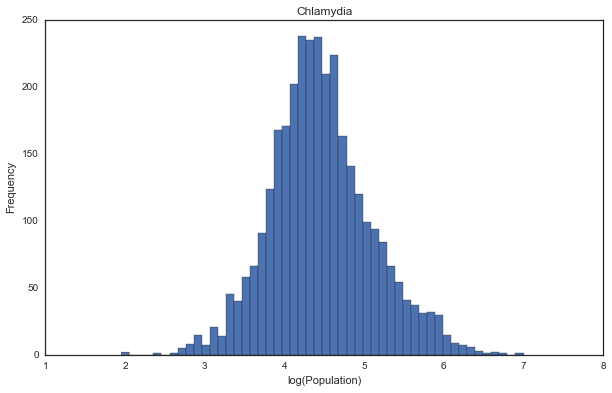

In [15]:
fig = plt.figure(figsize=(10, 6))
data = np.log10(df['Population'])
ax = data.plot.hist(50)
ax.set_xlabel("log(Population)")
ax.set_title("Chlamydia")
plt.savefig('../graphics/county_population.png', bbox_inches='tight', dpi=150)

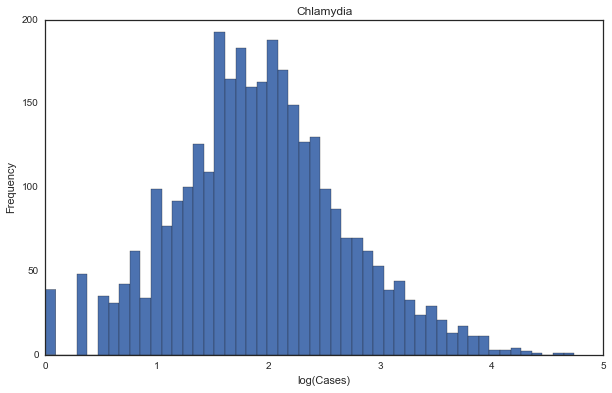

In [16]:
fig = plt.figure(figsize=(10, 6))
data = np.log10(df['Cases']+1)
ax = data.plot.hist(50)
ax.set_xlabel("log(Cases)")
ax.set_title("Chlamydia")
plt.savefig('../graphics/county_cases.png', bbox_inches='tight', dpi=150)

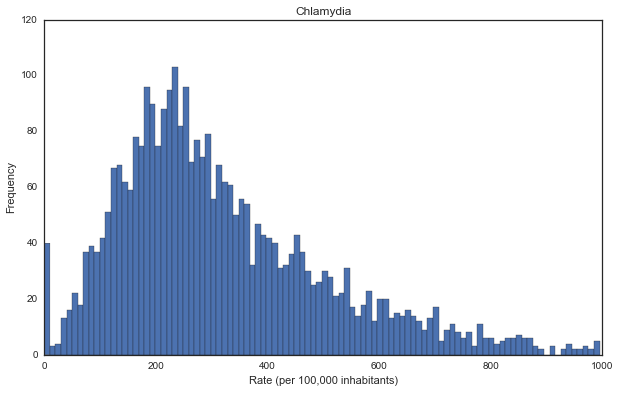

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = df['Rate'].plot.hist(100)
ax.set_xlabel("Rate (per 100,000 inhabitants)")
ax.set_title("Chlamydia")
plt.savefig('../graphics/county_rate.png', bbox_inches='tight', dpi=150)

In [18]:
outliers = df[df['Rate']<50]

In [19]:
outliers

,Disease,Area,State Abbreviation,FIPS,Year,Race,Sex,Age group,Transmission Category,Population,Cases,Rate
88,Chlamydia,Prince of Wales - Outer Ketchikan,AK,2201,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,5786,0,0.0
96,Chlamydia,Wrangell-Petersburg Census Area,AK,2280,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,6174,0,0.0
256,Chlamydia,Cheyenne County,CO,8017,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,1890,0,0.0
274,Chlamydia,Hinsdale County,CO,8053,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,813,0,0.0
278,Chlamydia,Kiowa County,CO,8061,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,1423,0,0.0
322,Chlamydia,District Of Columbia,DC,11001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,646449,2,0.3
551,Chlamydia,Kalawao County,HI,15005,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,90,0,0.0
565,Chlamydia,Butte County,ID,16023,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,2642,1,37.9
586,Chlamydia,Madison County,ID,16065,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,37450,15,40.1
902,Chlamydia,Cheyenne County,KS,20023,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,2694,1,37.1


In [20]:
not_exclude_list = df["Cases"]<0
exclude_list = [not i for i in not_exclude_list]
df_sig = df[exclude_list].copy()

In [21]:
df = df_sig.copy()

People in D.C. don't have Chlamydia. Or so it seems.

I will have to remove the entries with very low numbers of Chlamydia cases.

In [22]:
df["Rate"].sort_values()

2040     0
2016     0
1623     0
1763     0
2385     0
278      0
1550     0
2036     0
1714     0
274      0
2657     0
2656     0
1694     0
980      0
551      0
96       0
256      0
1702     0
88       0
1664     0
2612     0
1635     0
941      0
1432     0
1739     0
2676     0
1659     0
1661     0
1628     0
3136     0
        ..
1995   NaN
2023   NaN
2032   NaN
2035   NaN
2297   NaN
2335   NaN
2349   NaN
2352   NaN
2356   NaN
2372   NaN
2375   NaN
2379   NaN
2384   NaN
2420   NaN
2424   NaN
2434   NaN
2539   NaN
2919   NaN
2926   NaN
2927   NaN
2930   NaN
2933   NaN
2942   NaN
2944   NaN
2946   NaN
2947   NaN
2948   NaN
3090   NaN
3146   NaN
3148   NaN
Name: Rate, dtype: float64

In [23]:
len(df['Area'].unique())

1962

In [24]:
df.shape

(3228, 12)

In [25]:
df.sort_values(by='Area')

,Disease,Area,State Abbreviation,FIPS,Year,Race,Sex,Age group,Transmission Category,Population,Cases,Rate
2319,Chlamydia,Abbeville County,SC,45001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,25007,117,467.9
1116,Chlamydia,Acadia Parish,LA,22001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,62204,285,458.2
2823,Chlamydia,Accomack County,VA,51001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,33148,262,790.4
554,Chlamydia,Ada County,ID,16001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,416464,1529,367.1
996,Chlamydia,Adair County,KY,21001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,18732,46,245.6
1486,Chlamydia,Adair County,MO,29001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,25572,70,273.7
792,Chlamydia,Adair County,IA,19001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,7472,7,93.7
2134,Chlamydia,Adair County,OK,40001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,22194,128,576.7
1657,Chlamydia,Adams County,NE,31001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,31610,87,275.2
700,Chlamydia,Adams County,IN,18001,2014,All races/ethnicities,Both sexes,All age groups,All transmission categories,34614,43,124.2


In [26]:
df['Area'].value_counts()

Washington County       30
Jefferson County        25
Franklin County         24
Lincoln County          23
Jackson County          23
Madison County          19
Montgomery County       18
Clay County             18
Monroe County           17
Marion County           17
Union County            17
Wayne County            16
Greene County           14
Warren County           14
Grant County            14
Carroll County          13
Douglas County          12
Lee County              12
Adams County            12
Johnson County          12
Polk County             12
Lake County             12
Marshall County         12
Clark County            12
Crawford County         11
Calhoun County          11
Scott County            11
Morgan County           11
Fayette County          11
Lawrence County         11
                        ..
Cattaraugus County       1
Snyder County            1
Sac County               1
Gillespie County         1
Musselshell County       1
Hodgeman County          1
G

In [27]:
df.isnull().values.any()

True

In [28]:
null_list = df["Population"].isnull()
not_null_list = [not i for i in null_list]
df_clean = df[not_null_list].copy()

In [29]:
null_list = df_clean["Rate"].isnull()
not_null_list = [not i for i in null_list]
df_completely_clean = df_clean[not_null_list].copy()

In [30]:
df_completely_clean["Rate"].isnull().values.any()

False

## Get ZIP codes and FIPS codes for counties

We will need a mapping function for ZIP codes and for FIPS codes. ZIP codes are used by USPS and are generally known by the users, whereas governmental studies and CDC data usually use FIPS codes for regions. 

In [31]:
df_fipszip= pd.read_csv("../data/COUNTY_ZIP_122014.csv", usecols={0,1})

In [32]:
df_fipszip.shape

(51280, 2)

In [33]:
df_fipszip.head()

,COUNTY,ZIP
0,1001,36051
1,1001,36066
2,1001,36703
3,1001,36068
4,1001,36749


In [34]:
df_zipfips= pd.read_csv("../data/ZIP_COUNTY_122014.csv", usecols={0,1})

In [35]:
df_zipfips.shape

(51280, 2)

In [36]:
df_zipfips.head()

,ZIP,COUNTY
0,501,36103
1,601,72001
2,602,72003
3,603,72005
4,604,72005


In [37]:
df_zipfips.dtypes

ZIP       int64
COUNTY    int64
dtype: object

In [38]:
zip2fips = dict(zip(df_zipfips["ZIP"], df_zipfips["COUNTY"]))

In [39]:
zip2fips[65536]

29105

In [40]:
fips2zip = {}

In [41]:
for fips in np.arange(len(df_fipszip.COUNTY)):
    if df_fipszip.COUNTY[fips] in fips2zip:
        fips2zip[df_fipszip.COUNTY[fips]].append(df_fipszip.ZIP[fips])
    else:
        fips2zip[df_fipszip.COUNTY[fips]] = []
        fips2zip[df_fipszip.COUNTY[fips]].append(df_fipszip.ZIP[fips])

In [42]:
fips2zip[1001]

[36051,
 36066,
 36703,
 36068,
 36749,
 36006,
 36067,
 36022,
 36091,
 36758,
 36003,
 36008]

In [43]:
df_fipszip.COUNTY[1]

1001

In [44]:
fips2zip[zip2fips[754]]

[754]

In [45]:
df_fipszip['COUNTY'].value_counts()

6037     498
48201    229
17031    225
11001    219
4013     193
6073     178
6059     145
42003    144
48113    140
36061    135
12086    122
6071     122
53033    119
32003    114
36103    111
25017    107
9003     107
6085     106
48439    104
48029    104
6065     104
6019     103
25027    102
42129     94
42091     92
48453     90
26125     90
36029     90
1073      88
12057     87
        ... 
72129      1
72019      1
51515      1
31007      1
48261      1
31117      1
72065      1
72121      1
72125      1
72093      1
51720      1
72027      1
35028      1
48431      1
72045      1
48155      1
51530      1
48271      1
51580      1
48413      1
72051      1
72095      1
72143      1
48137      1
72111      1
48301      1
72079      1
72059      1
72047      1
72043      1
Name: COUNTY, dtype: int64

In [46]:
df_fipszip[df_fipszip["COUNTY"] == 72129]

,COUNTY,ZIP
51244,72129,754


## Census data for counties

In [47]:
df_census = pd.read_csv("../data/census/DEC_10_general.csv", header=0, skiprows={1})
df_census_labels = pd.read_csv("../data/census/DEC_10_general_metadata.csv", header=0, nrows=1)

In [48]:
df_census.shape, df_census_labels.shape

((3143, 375), (1, 2))

In [49]:
df_census_labels

,GEO.id,Id
0,GEO.id2,Id2


In [50]:
df_census.head()

,GEO.id,GEO.id2,GEO.display-label,HD01_S001,HD02_S001,HD01_S002,HD02_S002,HD01_S003,HD02_S003,HD01_S004,HD02_S004,HD01_S005,HD02_S005,HD01_S006,HD02_S006,HD01_S007,HD02_S007,HD01_S008,HD02_S008,HD01_S009,HD02_S009,HD01_S010,HD02_S010,HD01_S011,HD02_S011,HD01_S012,HD02_S012,HD01_S013,HD02_S013,HD01_S014,HD02_S014,HD01_S015,HD02_S015,HD01_S016,HD02_S016,HD01_S017,HD02_S017,HD01_S018,HD02_S018,HD01_S019,HD02_S019,HD01_S020,HD02_S020,HD01_S021,HD02_S021,HD01_S022,HD02_S022,HD01_S023,HD02_S023,HD01_S024,HD02_S024,HD01_S025,HD02_S025,HD01_S026,HD02_S026,HD01_S027,HD02_S027,HD01_S028,HD02_S028,HD01_S029,HD02_S029,HD01_S030,HD02_S030,HD01_S031,HD02_S031,HD01_S032,HD02_S032,HD01_S033,HD02_S033,HD01_S034,HD02_S034,HD01_S035,HD02_S035,HD01_S036,HD02_S036,HD01_S037,HD02_S037,HD01_S038,HD02_S038,HD01_S039,HD02_S039,HD01_S040,HD02_S040,HD01_S041,HD02_S041,HD01_S042,HD02_S042,HD01_S043,HD02_S043,HD01_S044,HD02_S044,HD01_S045,HD02_S045,HD01_S046,HD02_S046,HD01_S047,HD02_S047,HD01_S048,HD02_S048,HD01_S049,...,HD01_S137,HD02_S137,HD01_S138,HD02_S138,HD01_S139,HD02_S139,HD01_S140,HD02_S140,HD01_S141,HD02_S141,HD01_S142,HD02_S142,HD01_S143,HD02_S143,HD01_S144,HD02_S144,HD01_S145,HD02_S145,HD01_S146,HD02_S146,HD01_S147,HD02_S147,HD01_S148,HD02_S148,HD01_S149,HD02_S149,HD01_S150,HD02_S150,HD01_S151,HD02_S151,HD01_S152,HD02_S152,HD01_S153,HD02_S153,HD01_S154,HD02_S154,HD01_S155,HD02_S155,HD01_S156,HD02_S156,HD01_S157,HD02_S157,HD01_S158,HD02_S158,HD01_S159,HD02_S159,HD01_S160,HD02_S160,HD01_S161,HD02_S161,HD01_S162,HD02_S162,HD01_S163,HD02_S163,HD01_S164,HD02_S164,HD01_S165,HD02_S165,HD01_S166,HD02_S166,HD01_S167,HD02_S167,HD01_S168,HD02_S168,HD01_S169,HD02_S169,HD01_S170,HD02_S170,HD01_S171,HD02_S171,HD01_S172,HD02_S172,HD01_S173,HD02_S173,HD01_S174,HD02_S174,HD01_S175,HD02_S175,HD01_S176,HD02_S176,HD01_S177,HD02_S177,HD01_S178,HD02_S178,HD01_S179,HD02_S179,HD01_S180,HD02_S180,HD01_S181,HD02_S181,HD01_S182,HD02_S182,HD01_S183,HD02_S183,HD01_S184,HD02_S184,HD01_S185,HD02_S185,HD01_S186,HD02_S186
0,0500000US01001,1001,"Autauga County, Alabama",54571,100,3579,6.6,3991,7.3,4290,7.9,4290,7.9,3080,5.6,3157,5.8,3330,6.1,4157,7.6,4086,7.5,4332,7.9,3873,7.1,3083,5.6,2777,5.1,2277,4.2,1736,3.2,1251,2.3,731,1.3,551,1.0,37.0,( X ),41804,76.6,39958,73.2,37756,69.2,8222,15.1,6546,12.0,26569,48.7,1866,3.4,2001,3.7,2171,4.0,2213,4.1,1539,2.8,1543,2.8,1594,2.9,2004,3.7,1974,3.6,2174,4.0,1866,3.4,1524,2.8,1279,2.3,1014,1.9,807,1.5,546,1.0,295,0.5,159,0.3,35.9,( X ),20046,36.7,19114,35.0,17968,32.9,3606,...,1551,2.8,425,0.8,1859,3.4,167,0.3,75,0.1,882,1.6,455,0.8,362,0.7,194,0.4,168,0.3,93,0.2,62,0.1,31,0.1,20221,100,15064,74.5,7065,34.9,11367,56.2,5110,25.3,934,4.6,474,2.3,2763,13.7,1481,7.3,5157,25.5,4441,22.0,2012,10.0,417,2.1,2429,12.0,1187,5.9,7972,39.4,4733,23.4,2.68,( X ),3.13,( X ),22135,100,20221,91.4,1914,8.6,429,1.9,30,0.1,305,1.4,62,0.3,266,1.2,822,3.7,2.0,( X ),7.9,( X ),20221,100,15248,75.4,40942,( X ),2.69,( X ),4973,24.6,13174,( X ),2.65,( X )
1,0500000US01003,1003,"Baldwin County, Alabama",182265,100,11158,6.1,11599,6.4,11926,6.5,11600,6.4,9449,5.2,10247,5.6,10709,5.9,11558,6.3,11995,6.6,13431,7.4,13490,7.4,12523,6.9,12012,6.6,10174,5.6,7629,4.2,5598,3.1,3934,2.2,3233,1.8,41.1,( X ),145215,79.7,140367,77.0,134024,73.5,37780,20.7,30568,16.8,89196,48.9,5614,3.1,5832,3.2,6076,3.3,5930,3.3,4793,2.6,5183,2.8,5317,2.9,5725,3.1,5895,3.2,6622,3.6,6425,3.5,5943,3.3,5728,3.1,4895,2.7,3663,2.0,2644,1.5,1735,1.0,1176,0.6,40.1,( X ),70491,38.7,67970,37.3,64731,35.5,17540,...,4542,2.5,1356,0.7,7931,4.4,651,0.4,427,0.2,3686,2.0,2307,1.3,1744,1.0,1282,0.7,462,0.3,563,0.3,259,0.1,304,0.2,73180,100,51151,69.9,20472,28.0,39913,54.5,14559,19.9,3094,4.2,1558,2.1,8144,11.1,4355,6.0,22029,30.1,18372,25.1,8096,11.1,2159,3.0,10276,14.0,5269,7.2,23224,31.7,21733,29.7,2.46,( X ),2.93,( X ),104061,100,73180,70.3,30881,29.7,7822,7.5,188,0.2,2837,2.7,343,0.3,16931,16.3,2760,2.7,5.0,( X ),27.8,( X ),73180,100,53071,72.5,131251,( X ),2.47,( X ),20109,27.5,48707,( X ),2.42,( X )
2,0

In [51]:
df_census.convert_objects(convert_numeric=True)
df_census.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


GEO.id                object
GEO.id2                int64
GEO.display-label     object
HD01_S001             object
HD02_S001              int64
HD01_S002              int64
HD02_S002            float64
HD01_S003              int64
HD02_S003            float64
HD01_S004              int64
HD02_S004            float64
HD01_S005              int64
HD02_S005            float64
HD01_S006              int64
HD02_S006            float64
HD01_S007              int64
HD02_S007            float64
HD01_S008              int64
HD02_S008            float64
HD01_S009              int64
HD02_S009            float64
HD01_S010              int64
HD02_S010            float64
HD01_S011              int64
HD02_S011            float64
HD01_S012              int64
HD02_S012            float64
HD01_S013              int64
HD02_S013            float64
HD01_S014              int64
                      ...   
HD01_S172              int64
HD02_S172            float64
HD01_S173              int64
HD02_S173     

In [52]:
columnnames = list(df_census.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)
    df_census_labels.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

geoid
geoid2
geodisplaylabel
hd01s001
hd02s001
hd01s002
hd02s002
hd01s003
hd02s003
hd01s004
hd02s004
hd01s005
hd02s005
hd01s006
hd02s006
hd01s007
hd02s007
hd01s008
hd02s008
hd01s009
hd02s009
hd01s010
hd02s010
hd01s011
hd02s011
hd01s012
hd02s012
hd01s013
hd02s013
hd01s014
hd02s014
hd01s015
hd02s015
hd01s016
hd02s016
hd01s017
hd02s017
hd01s018
hd02s018
hd01s019
hd02s019
hd01s020
hd02s020
hd01s021
hd02s021
hd01s022
hd02s022
hd01s023
hd02s023
hd01s024
hd02s024
hd01s025
hd02s025
hd01s026
hd02s026
hd01s027
hd02s027
hd01s028
hd02s028
hd01s029
hd02s029
hd01s030
hd02s030
hd01s031
hd02s031
hd01s032
hd02s032
hd01s033
hd02s033
hd01s034
hd02s034
hd01s035
hd02s035
hd01s036
hd02s036
hd01s037
hd02s037
hd01s038
hd02s038
hd01s039
hd02s039
hd01s040
hd02s040
hd01s041
hd02s041
hd01s042
hd02s042
hd01s043
hd02s043
hd01s044
hd02s044
hd01s045
hd02s045
hd01s046
hd02s046
hd01s047
hd02s047
hd01s048
hd02s048
hd01s049
hd02s049
hd01s050
hd02s050
hd01s051
hd02s051
hd01s052
hd02s052
hd01s053
hd02s053
hd01s054
hd02s054

In [53]:
df_census_clean = df_census.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid               object
geoid2               int64
geodisplaylabel     object
hd01s001             int64
hd02s001             int64
hd01s002             int64
hd02s002           float64
hd01s003             int64
hd02s003           float64
hd01s004             int64
hd02s004           float64
hd01s005             int64
hd02s005           float64
hd01s006             int64
hd02s006           float64
hd01s007             int64
hd02s007           float64
hd01s008             int64
hd02s008           float64
hd01s009             int64
hd02s009           float64
hd01s010             int64
hd02s010           float64
hd01s011             int64
hd02s011           float64
hd01s012             int64
hd02s012           float64
hd01s013             int64
hd02s013           float64
hd01s014             int64
                    ...   
hd01s172             int64
hd02s172           float64
hd01s173             int64
hd02s173           float64
hd01s174             int64
hd02s174           float64
h

In [54]:
df_census_clean.describe()

,geoid2,hd01s001,hd02s001,hd01s002,hd02s002,hd01s003,hd02s003,hd01s004,hd02s004,hd01s005,hd02s005,hd01s006,hd02s006,hd01s007,hd02s007,hd01s008,hd02s008,hd01s009,hd02s009,hd01s010,hd02s010,hd01s011,hd02s011,hd01s012,hd02s012,hd01s013,hd02s013,hd01s014,hd02s014,hd01s015,hd02s015,hd01s016,hd02s016,hd01s017,hd02s017,hd01s018,hd02s018,hd01s019,hd02s019,hd01s020,hd01s021,hd02s021,hd01s022,hd02s022,hd01s023,hd02s023,hd01s024,hd02s024,hd01s025,hd02s025,hd01s026,hd02s026,hd01s027,hd02s027,hd01s028,hd02s028,hd01s029,hd02s029,hd01s030,hd02s030,hd01s031,hd02s031,hd01s032,hd02s032,hd01s033,hd02s033,hd01s034,hd02s034,hd01s035,hd02s035,hd01s036,hd02s036,hd01s037,hd02s037,hd01s038,hd02s038,hd01s039,hd02s039,hd01s040,hd02s040,hd01s041,hd02s041,hd01s042,hd02s042,hd01s043,hd02s043,hd01s044,hd02s044,hd01s045,hd01s046,hd02s046,hd01s047,hd02s047,hd01s048,hd02s048,hd01s049,hd02s049,hd01s050,hd02s050,hd01s051,...,hd01s133,hd02s133,hd01s134,hd02s134,hd01s135,hd02s135,hd01s136,hd02s136,hd01s137,hd02s137,hd01s138,hd02s138,hd01s139,hd02s139,hd01s140,hd02s140,hd01s141,hd02s141,hd01s142,hd02s142,hd01s143,hd02s143,hd01s144,hd02s144,hd01s145,hd02s145,hd01s146,hd02s146,hd01s147,hd02s147,hd01s148,hd02s148,hd01s149,hd02s149,hd01s150,hd02s150,hd01s151,hd02s151,hd01s152,hd02s152,hd01s153,hd02s153,hd01s154,hd02s154,hd01s155,hd02s155,hd01s156,hd02s156,hd01s157,hd02s157,hd01s158,hd02s158,hd01s159,hd02s159,hd01s160,hd02s160,hd01s161,hd02s161,hd01s162,hd02s162,hd01s163,hd02s163,hd01s164,hd02s164,hd01s165,hd02s165,hd01s166,hd02s166,hd01s167,hd01s168,hd01s169,hd02s169,hd01s170,hd02s170,hd01s171,hd02s171,hd01s172,hd02s172,hd01s173,hd02s173,hd01s174,hd02s174,hd01s175,hd02s175,hd01s176,hd02s176,hd01s177,hd02s177,hd01s178,hd01s179,hd01s180,hd02s180,hd01s181,hd02s181,hd01s182,hd01s183,hd01s184,hd02s184,hd01s185,hd01s186
count,3143.000000,3143.000000,3143,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.00000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,...,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3

In [55]:
df_census_labels

,geoid,Id
0,GEO.id2,Id2


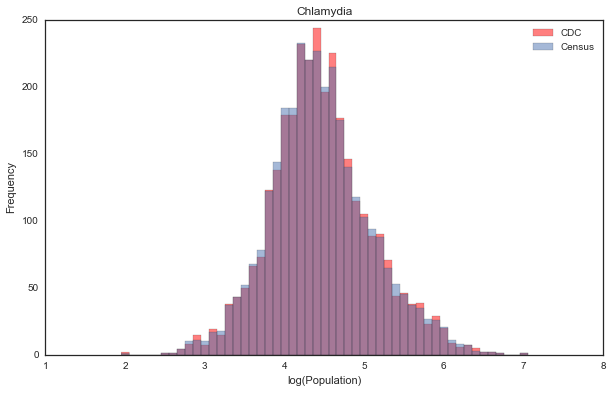

In [56]:
fig = plt.figure(figsize=(10, 6))
data = np.log10(df_completely_clean['Population'])
binwidth = 0.1
bins=np.arange(min(data), max(data) + binwidth, binwidth)

ax = data.plot.hist(bins=bins, alpha=0.5, label='CDC', color='red')
ax.set_xlabel("log(Population)")
ax.set_title("Chlamydia")

data2 = np.log10(df_census_clean["hd01s001"])
ax2 = data2.plot.hist(bins=bins, alpha=0.5, label='Census')

plt.legend()
plt.savefig('../graphics/county_population_comparison.png', bbox_inches='tight', dpi=150)

In [57]:
data = np.log10(df_completely_clean['Population'])
data2 = np.log10(df_census_clean["hd01s001"])
len(data), len(data2)

(3143, 3143)

In [58]:
true = df_completely_clean["FIPS"].isin(df_census_clean["geoid2"])
true.head()#.sort_values()

0    True
1    True
2    True
3    True
4    True
Name: FIPS, dtype: bool

In [59]:
not_in_census = set(df_completely_clean["FIPS"])-set(df_census_clean["geoid2"])
len(not_in_census)

83

Select a subset of the data for modeling:

In [60]:
df_census_subset = df_census_clean[["geoid2",
                                    "hd01s001",  #log10(population)
                                    "hd02s002",  #under 5 yrs
                                    "hd02s003",  #5-9 yrs 
                                    "hd02s004",  #10-14
                                    "hd02s005",  #15-19
                                    "hd02s006",  #20-24
                                    "hd02s007",  #25-29
                                    "hd02s008",  #30-34
                                    "hd02s009",  #35-39
                                    "hd02s010",  #40-44
                                    "hd02s011",  #45-49
                                    "hd02s012",  #50-54
                                    "hd02s013",  #55-59
                                    "hd02s014",  #60-64
                                    "hd02s015",  #65-69
                                    "hd02s016",  #70-74
                                    "hd02s017",  #75-79
                                    "hd02s018",  #80-84
                                    "hd02s019",  #85 and over
                                    "hd01s020",  #median age
                                    "hd02s026",  #male percent
                                    "hd02s051",  #female percent
                                    "hd02s078",  #white
                                    "hd02s079",  #black
                                    "hd02s080",  #native
                                    "hd02s081",  #asian
                                    "hd02s089",  #pacific
                                    "hd02s095",  #two or more
                                    "hd02s107",  #hispanic
                                    "hd02s131",  #in households
                                    "hd02s132",  #householder
                                    "hd02s133",  #spouse
                                    "hd02s134",  #child
                                    "hd02s135",  #child w own child under 18
                                    "hd02s136",  #other relatives
                                    "hd02s143",  #in group quarters
                                    "hd02s151",  #family households
                                    "hd02s152",  #family households w own child under 18
                                    "hd02s153",  #husband-wife family
                                    "hd02s154",  #husband-wife family w own child under 18
                                    "hd02s159",  #nonfamily households
                                    "hd01s167",  #average household size
                                    "hd01s168",  #average family size
                                    "hd02s181",  #owner occupied housing units
                                    "hd02s184"   #renter occupied housing units
                                   ]].copy()
df_census_subset.head()

,geoid2,hd01s001,hd02s002,hd02s003,hd02s004,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s012,hd02s013,hd02s014,hd02s015,hd02s016,hd02s017,hd02s018,hd02s019,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184
0,1001,54571,6.6,7.3,7.9,7.9,5.6,5.8,6.1,7.6,7.5,7.9,7.1,5.6,5.1,4.2,3.2,2.3,1.3,1.0,37.0,48.7,51.3,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,0.8,74.5,34.9,56.2,25.3,25.5,2.68,3.13,75.4,24.6
1,1003,182265,6.1,6.4,6.5,6.4,5.2,5.6,5.9,6.3,6.6,7.4,7.4,6.9,6.6,5.6,4.2,3.1,2.2,1.8,41.1,48.9,51.1,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,1.3,69.9,28.0,54.5,19.9,30.1,2.46,2.93,72.5,27.5
2,1005,27457,6.2,6.0,5.8,6.3,6.5,7.3,6.6,6.6,6.6,7.7,7.0,6.6,6.6,4.7,3.5,2.5,2.0,1.6,39.0,53.1,46.9,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,11.6,68.4,27.4,43.7,14.4,31.6,2.47,3.01,66.8,33.2
3,1007,22915,6.0,6.1,6.3,6.7,6.5,7.0,7.2,7.6,7.1,7.9,6.9,6.1,5.8,4.2,3.3,2.4,1.5,1.2,37.8,53.7,46.3,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,9.7,72.3,29.5,52.5,20.1,27.7,2.60,3.09,75.6,24.4
4,1009,57322,6.3,6.8,7.1,7.0,5.4,6.0,6.0,6.8,7.0,7.3,6.8,6.4,6.2,5.0,3.8,2.6,1.8,1.4,39.0,49.5,50.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,0.9,75.0,31.1,60.6,24.1,25.0,2.63,3.07,80.6,19.4


In [61]:
df_census_subset['hd01s001'] = df_census_subset['hd01s001'].apply(np.log10) 

In [62]:
df_census_subset['hd02s002'] = df_census_subset['hd02s002']+df_census_subset['hd02s003']+df_census_subset['hd02s004'] 
df_census_subset['hd02s011'] = df_census_subset['hd02s011']+df_census_subset['hd02s012'] 
df_census_subset['hd02s013'] = df_census_subset['hd02s013']+df_census_subset['hd02s014'] 
df_census_subset['hd02s015'] = df_census_subset['hd02s015']+df_census_subset['hd02s016']+df_census_subset['hd02s017']+df_census_subset['hd02s018']+df_census_subset['hd02s019'] 

In [63]:
df_census_combined_subset = df_census_subset[["geoid2",
                                    "hd01s001",  #log10(population)
                                    "hd02s002",  #0-14
                                    "hd02s005",  #15-19
                                    "hd02s006",  #20-24
                                    "hd02s007",  #25-29
                                    "hd02s008",  #30-34
                                    "hd02s009",  #35-39
                                    "hd02s010",  #40-44
                                    "hd02s011",  #45-54
                                    "hd02s013",  #55-64
                                    "hd02s015",  #65+
                                    "hd01s020",  #median age
                                    "hd02s026",  #male percent
                                    "hd02s051",  #female percent
                                    "hd02s078",  #white
                                    "hd02s079",  #black
                                    "hd02s080",  #native
                                    "hd02s081",  #asian
                                    "hd02s089",  #pacific
                                    "hd02s095",  #two or more
                                    "hd02s107",  #hispanic
                                    "hd02s131",  #in households
                                    "hd02s132",  #householder
                                    "hd02s133",  #spouse
                                    "hd02s134",  #child
                                    "hd02s135",  #child w own child under 18
                                    "hd02s136",  #other relatives
                                    "hd02s143",  #in group quarters
                                    "hd02s151",  #family households
                                    "hd02s152",  #family households w own child under 18
                                    "hd02s153",  #husband-wife family
                                    "hd02s154",  #husband-wife family w own child under 18
                                    "hd02s159",  #nonfamily households
                                    "hd01s167",  #average household size
                                    "hd01s168",  #average family size
                                    "hd02s181",  #owner occupied housing units
                                    "hd02s184"   #renter occupied housing units
                                   ]].copy()
df_census_combined_subset.head()

,geoid2,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184
0,1001,4.736962,21.8,7.9,5.6,5.8,6.1,7.6,7.5,15.0,10.7,12.0,37.0,48.7,51.3,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,0.8,74.5,34.9,56.2,25.3,25.5,2.68,3.13,75.4,24.6
1,1003,5.260703,19.0,6.4,5.2,5.6,5.9,6.3,6.6,14.8,13.5,16.9,41.1,48.9,51.1,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,1.3,69.9,28.0,54.5,19.9,30.1,2.46,2.93,72.5,27.5
2,1005,4.438653,18.0,6.3,6.5,7.3,6.6,6.6,6.6,14.7,13.2,14.3,39.0,53.1,46.9,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,11.6,68.4,27.4,43.7,14.4,31.6,2.47,3.01,66.8,33.2
3,1007,4.360120,18.4,6.7,6.5,7.0,7.2,7.6,7.1,14.8,11.9,12.6,37.8,53.7,46.3,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,9.7,72.3,29.5,52.5,20.1,27.7,2.60,3.09,75.6,24.4
4,1009,4.758321,20.2,7.0,5.4,6.0,6.0,6.8,7.0,14.1,12.6,14.6,39.0,49.5,50.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,0.9,75.0,31.1,60.6,24.1,25.0,2.63,3.07,80.6,19.4


In [64]:
df_cdc = df_completely_clean[true].copy()
df_cdc_subset = df_cdc[["FIPS","Population","Cases"]]
df_cdc_subset.shape

(3060, 3)

In [65]:
df_cdc_subset.head()

,FIPS,Population,Cases
0,1001,55246,220
1,1003,195540,667
2,1005,27076,166
3,1007,22512,100
4,1009,57872,72


In [66]:
true_new = df_cdc_subset["FIPS"].isin(df_census_clean["geoid2"])
true_new.describe()

count    3060
mean        1
std         0
min      True
25%         1
50%         1
75%         1
max      True
Name: FIPS, dtype: object

### Add income data

In [67]:
df_census_acs = pd.read_csv("../data/census/ACS_14_5YR_income.csv", header=0, skiprows={1})
df_census_acs_labels = pd.read_csv("../data/census/ACS_14_5YR_income_metadata.csv", header=0, nrows=1)

In [68]:
columnnames = list(df_census_acs.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census_acs.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)
    df_census_acs_labels.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

geoid
geoid2
geodisplaylabel
hd01vd01
hd02vd01


In [69]:
df_census_acs_clean = df_census_acs.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_acs_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid              object
geoid2              int64
geodisplaylabel    object
hd01vd01            int64
hd02vd01            int64
dtype: object

In [70]:
df_census_acs_clean.head()

,geoid,geoid2,geodisplaylabel,hd01vd01,hd02vd01
0,0500000US01001,1001,"Autauga County, Alabama",52475,2760
1,0500000US01003,1003,"Baldwin County, Alabama",50183,1378
2,0500000US01005,1005,"Barbour County, Alabama",35634,2440
3,0500000US01007,1007,"Bibb County, Alabama",37984,3295
4,0500000US01009,1009,"Blount County, Alabama",44409,2225


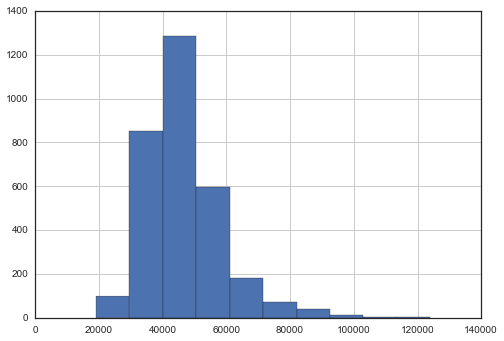

In [71]:
df_census_acs_clean["hd01vd01"].hist()

In [72]:
df_census_acs_labels

,geoid,Id
0,GEO.id2,Id2


In [73]:
true = df_completely_clean["FIPS"].isin(df_census_acs_clean["geoid2"])

In [74]:
not_in_census = set(df_completely_clean["FIPS"])-set(df_census_acs_clean["geoid2"])
len(not_in_census)

83

In [75]:
df_census_acs_clean.head()

,geoid,geoid2,geodisplaylabel,hd01vd01,hd02vd01
0,0500000US01001,1001,"Autauga County, Alabama",52475,2760
1,0500000US01003,1003,"Baldwin County, Alabama",50183,1378
2,0500000US01005,1005,"Barbour County, Alabama",35634,2440
3,0500000US01007,1007,"Bibb County, Alabama",37984,3295
4,0500000US01009,1009,"Blount County, Alabama",44409,2225


In [76]:
df_census_acs_subset = df_census_acs_clean[["geoid2",
                                    "hd01vd01"  #median income
                                   ]].copy()
df_census_acs_subset.head()

,geoid2,hd01vd01
0,1001,52475
1,1003,50183
2,1005,35634
3,1007,37984
4,1009,44409


### Add LGBT data

In [77]:
df_census_lgbt = pd.read_csv("../data/census/DEC_10_lgbt.csv", header=0, skiprows={1})
df_census_lgbt_labels = pd.read_csv("../data/census/DEC_10_lgbt_metadata.csv", header=0, nrows=1)

In [78]:
columnnames = list(df_census_lgbt.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census_lgbt.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)
    df_census_lgbt_labels.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

geoid
geoid2
geodisplaylabel
d001
d002
d003
d004
d005
d006
d007
d008
d009
d010
d011
d012
d013
d014
d015
d016
d017
d018
d019
d020
d021
d022
d023
d024
d025
d026
d027
d028
d029
d030
d031
d032
d033
d034


In [79]:
df_census_lgbt_clean = df_census_lgbt.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_lgbt_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid              object
geoid2              int64
geodisplaylabel    object
d001                int64
d002                int64
d003                int64
d004                int64
d005                int64
d006                int64
d007                int64
d008                int64
d009                int64
d010                int64
d011                int64
d012                int64
d013                int64
d014                int64
d015                int64
d016                int64
d017                int64
d018                int64
d019                int64
d020                int64
d021                int64
d022                int64
d023                int64
d024                int64
d025                int64
d026                int64
d027                int64
d028                int64
d029                int64
d030                int64
d031                int64
d032                int64
d033                int64
d034                int64
dtype: object

In [80]:
df_census_lgbt_clean.head()

,geoid,geoid2,geodisplaylabel,d001,d002,d003,d004,d005,d006,d007,d008,d009,d010,d011,d012,d013,d014,d015,d016,d017,d018,d019,d020,d021,d022,d023,d024,d025,d026,d027,d028,d029,d030,d031,d032,d033,d034
0,0500000US01001,1001,"Autauga County, Alabama",20221,11367,9813,4667,4321,346,5146,1554,855,789,66,699,882,61,13,12,1,48,405,165,156,9,240,58,18,18,0,40,358,184,171,13,174,7972
1,0500000US01003,1003,"Baldwin County, Alabama",73180,39913,33054,12586,11591,995,20468,6859,3192,2968,224,3667,3686,201,49,46,3,152,1748,597,561,36,1151,252,66,61,5,186,1485,663,640,23,822,29581
2,0500000US01005,1005,"Barbour County, Alabama",9820,4293,3466,1235,1073,162,2231,827,393,341,52,434,467,23,8,7,1,15,190,90,82,8,100,36,18,15,3,18,218,131,114,17,87,5060
3,0500000US01007,1007,"Bibb County, Alabama",7953,4172,3522,1455,1298,157,2067,650,334,301,33,316,354,15,9,8,1,6,161,55,51,4,106,16,7,6,1,9,162,94,88,6,68,3427
4,0500000US01009,1009,"Blount County, Alabama",21578,13077,11278,4800,4317,483,6478,1799,971,891,80,828,800,42,16,14,2,26,388,156,146,10,232,80,22,20,2,58,290,163,153,10,127,7701


In [81]:
true = df_completely_clean["FIPS"].isin(df_census_lgbt_clean["geoid2"])

In [82]:
not_in_census = set(df_completely_clean["FIPS"])-set(df_census_lgbt_clean["geoid2"])
len(not_in_census)

83

In [83]:
df_census_lgbt_subset = df_census_lgbt_clean[["geoid2",
                                    "d001",  #Total households
                                    "d002",  #Husband-wife households
                                    "d014",  #Unmarried-partner households: - Male householder and male partner
                                    "d019",  #Unmarried-partner households: - Male householder and female partner
                                    "d024",  #Unmarried-partner households: - Female householder and female partner
                                    "d029"   #Unmarried-partner households: - Female householder and male partner
                                   ]].copy()
df_census_lgbt_subset.head()

,geoid2,d001,d002,d014,d019,d024,d029
0,1001,20221,11367,61,405,58,358
1,1003,73180,39913,201,1748,252,1485
2,1005,9820,4293,23,190,36,218
3,1007,7953,4172,15,161,16,162
4,1009,21578,13077,42,388,80,290


In [84]:
df_census_lgbt_subset.describe()

,geoid2,d001,d002,d014,d019,d024,d029
count,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,30390.411709,37135.314031,17979.757238,135.309895,1136.566656,151.676106,1040.561565
std,15164.717720,111974.893658,51305.844438,599.157691,3529.334381,504.522984,3227.563877
min,1001.000000,39.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,18178.000000,4367.500000,2293.000000,9.000000,127.000000,12.000000,100.000000
50%,29177.000000,10014.000000,5192.000000,23.000000,303.000000,31.000000,246.000000
75%,45082.000000,25818.000000,13139.000000,66.000000,824.000000,91.000000,710.500000
max,56045.000000,3241204.000000,1480665.000000,18185.000000,110488.000000,14519.000000,90407.000000


In [85]:
df_census_lgbt_subset["d002"] = df_census_lgbt_subset["d002"]/df_census_lgbt_subset["d001"]
df_census_lgbt_subset["d014"] = df_census_lgbt_subset["d014"]/df_census_lgbt_subset["d001"]
df_census_lgbt_subset["d019"] = df_census_lgbt_subset["d019"]/df_census_lgbt_subset["d001"]
df_census_lgbt_subset["d024"] = df_census_lgbt_subset["d024"]/df_census_lgbt_subset["d001"]
df_census_lgbt_subset["d029"] = df_census_lgbt_subset["d029"]/df_census_lgbt_subset["d001"]

In [86]:
df_census_lgbt_subset.describe()

,geoid2,d001,d002,d014,d019,d024,d029
count,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000,3143.000000
mean,30390.411709,37135.314031,0.516816,0.002506,0.030704,0.003232,0.024897
std,15164.717720,111974.893658,0.064012,0.001299,0.007911,0.001300,0.007931
min,1001.000000,39.000000,0.115942,0.000000,0.000000,0.000000,0.000000
25%,18178.000000,4367.500000,0.484253,0.001803,0.025409,0.002473,0.020098
50%,29177.000000,10014.000000,0.523133,0.002375,0.030214,0.003172,0.024544
75%,45082.000000,25818.000000,0.556148,0.003008,0.035367,0.003855,0.029104
max,56045.000000,3241204.000000,0.792199,0.022064,0.083668,0.017631,0.100173


In [87]:
df_census_lgbt_subset.drop('d001', axis=1, inplace=True)

## Merge the data sets into one data frame

In [88]:
df_merged = pd.merge(df_cdc_subset, df_census_combined_subset, left_on='FIPS', right_on='geoid2', how='inner', sort=False)

In [89]:
df_merged2 = pd.merge(df_merged, df_census_acs_subset, left_on='FIPS', right_on='geoid2', how='inner', sort=False)

In [90]:
df_merged = pd.merge(df_merged2, df_census_lgbt_subset, left_on='FIPS', right_on='geoid2', how='inner', sort=False)

In [91]:
df_merged.head()

,FIPS,Population,Cases,geoid2_x,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,geoid2_y,hd01vd01,geoid2,d002,d014,d019,d024,d029
0,1001,55246,220,1001,4.736962,21.8,7.9,5.6,5.8,6.1,7.6,7.5,15.0,10.7,12.0,37.0,48.7,51.3,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,0.8,74.5,34.9,56.2,25.3,25.5,2.68,3.13,75.4,24.6,1001,52475,1001,0.562138,0.003017,0.020029,0.002868,0.017704
1,1003,195540,667,1003,5.260703,19.0,6.4,5.2,5.6,5.9,6.3,6.6,14.8,13.5,16.9,41.1,48.9,51.1,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,1.3,69.9,28.0,54.5,19.9,30.1,2.46,2.93,72.5,27.5,1003,50183,1003,0.545409,0.002747,0.023886,0.003444,0.020292
2,1005,27076,166,1005,4.438653,18.0,6.3,6.5,7.3,6.6,6.6,6.6,14.7,13.2,14.3,39.0,53.1,46.9,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,11.6,68.4,27.4,43.7,14.4,31.6,2.47,3.01,66.8,33.2,1005,35634,1005,0.437169,0.002342,0.019348,0.003666,0.022200
3,1007,22512,100,1007,4.360120,18.4,6.7,6.5,7.0,7.2,7.6,7.1,14.8,11.9,12.6,37.8,53.7,46.3,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,9.7,72.3,29.5,52.5,20.1,27.7,2.60,3.09,75.6,24.4,1007,37984,1007,0.524582,0.001886,0.020244,0.002012,0.020370
4,1009,57872,72,1009,4.758321,20.2,7.0,5.4,6.0,6.0,6.8,7.0,14.1,12.6,14.6,39.0,49.5,50.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,0.9,75.0,31.1,60.6,24.1,25.0,2.63,3.07,80.6,19.4,1009,44409,1009,0.606034,0.001946,0.017981,0.003707,0.013440


In [92]:
df_merged.drop('geoid2_x', axis=1, inplace=True)
df_merged.drop('geoid2', axis=1, inplace=True)
df_merged.drop('geoid2_y', axis=1, inplace=True)

In [93]:
df_merged.head()

,FIPS,Population,Cases,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,hd01vd01,d002,d014,d019,d024,d029
0,1001,55246,220,4.736962,21.8,7.9,5.6,5.8,6.1,7.6,7.5,15.0,10.7,12.0,37.0,48.7,51.3,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,0.8,74.5,34.9,56.2,25.3,25.5,2.68,3.13,75.4,24.6,52475,0.562138,0.003017,0.020029,0.002868,0.017704
1,1003,195540,667,5.260703,19.0,6.4,5.2,5.6,5.9,6.3,6.6,14.8,13.5,16.9,41.1,48.9,51.1,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,1.3,69.9,28.0,54.5,19.9,30.1,2.46,2.93,72.5,27.5,50183,0.545409,0.002747,0.023886,0.003444,0.020292
2,1005,27076,166,4.438653,18.0,6.3,6.5,7.3,6.6,6.6,6.6,14.7,13.2,14.3,39.0,53.1,46.9,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,11.6,68.4,27.4,43.7,14.4,31.6,2.47,3.01,66.8,33.2,35634,0.437169,0.002342,0.019348,0.003666,0.022200
3,1007,22512,100,4.360120,18.4,6.7,6.5,7.0,7.2,7.6,7.1,14.8,11.9,12.6,37.8,53.7,46.3,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,9.7,72.3,29.5,52.5,20.1,27.7,2.60,3.09,75.6,24.4,37984,0.524582,0.001886,0.020244,0.002012,0.020370
4,1009,57872,72,4.758321,20.2,7.0,5.4,6.0,6.0,6.8,7.0,14.1,12.6,14.6,39.0,49.5,50.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,0.9,75.0,31.1,60.6,24.1,25.0,2.63,3.07,80.6,19.4,44409,0.606034,0.001946,0.017981,0.003707,0.013440


In [94]:
df_merged.shape

(3060, 46)

<Container object of 46 artists>

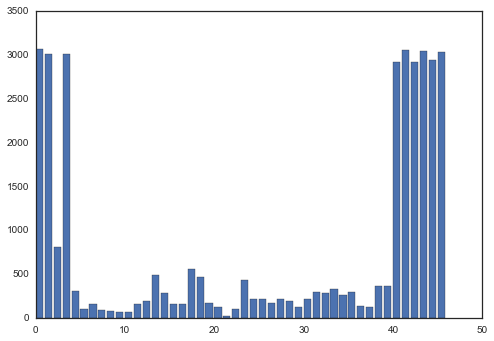

In [95]:
unique_values = [len(np.unique(df_merged.values[:,i])) for i in range(df_merged.values.shape[1])] 
plt.bar(range(df_merged.values.shape[1]), unique_values)

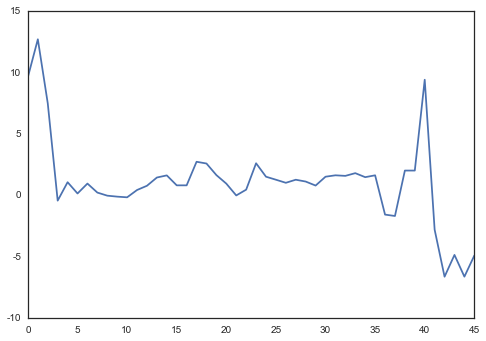

In [96]:
plt.plot(np.log(np.std(df_merged.values, axis=0)))

In [97]:
df_merged.to_csv("../data/chlamydia_cdc_census.csv", index=False)

In [98]:
df_merged.shape

(3060, 46)

## Model the Chlamydia rate

In [99]:
df_merged = pd.read_csv("../data/chlamydia_cdc_census.csv")

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


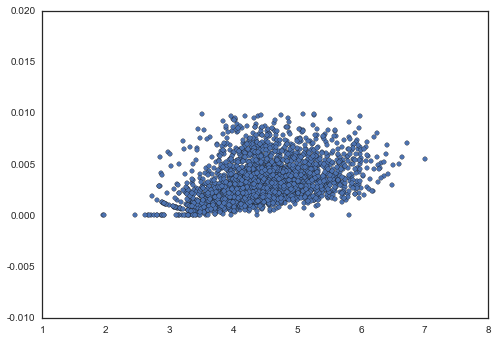

In [100]:
plt.scatter(np.log10(df_merged["Population"]), df_merged["Cases"]/df_merged["Population"])

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


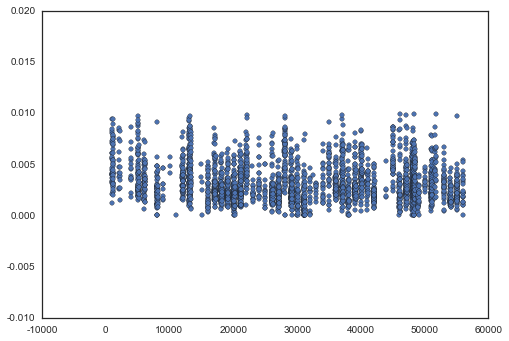

In [101]:
plt.scatter(df_merged["FIPS"], df_merged["Cases"]/df_merged["Population"])

### Plot the correlation matrix

In [102]:
df_all = df_merged.copy()
df_all["Rate"] = df_all["Cases"]/df_all["Population"]
corr = df_all.corr()

In [103]:
pearsonr = corr["Rate"]
pearsonr

FIPS         -0.096268
Population    0.180889
Cases         0.245175
hd01s001      0.360188
hd02s002      0.190625
hd02s005      0.304432
hd02s006      0.395677
hd02s007      0.459995
hd02s008      0.325028
hd02s009      0.178515
hd02s010      0.016332
hd02s011     -0.351527
hd02s013     -0.371801
hd02s015     -0.387918
hd01s020     -0.469234
hd02s026     -0.150985
hd02s051      0.150985
hd02s078     -0.702417
hd02s079      0.629293
hd02s080      0.184687
hd02s081      0.143452
hd02s089     -0.007155
hd02s095      0.214384
hd02s107      0.154928
hd02s131     -0.123808
hd02s132     -0.271132
hd02s133     -0.687693
hd02s134      0.175148
hd02s135     -0.021083
hd02s136      0.575035
hd02s143      0.123800
hd02s151     -0.084822
hd02s152      0.168630
hd02s153     -0.603637
hd02s154     -0.180042
hd02s159      0.084810
hd01s167      0.217388
hd01s168      0.328821
hd02s181     -0.492802
hd02s184      0.492803
hd01vd01     -0.173462
d002         -0.603659
d014          0.149278
d019       

In [104]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


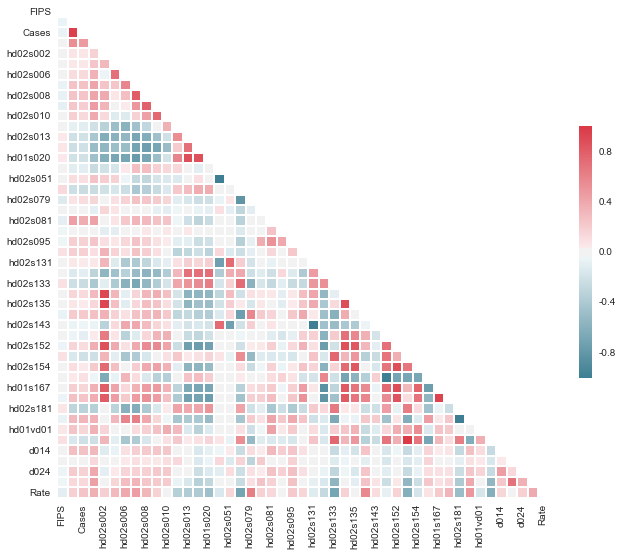

In [106]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

plt.savefig('../graphics/cross-correlation.png', bbox_inches='tight', dpi=150)

### Make principal component analysis

In [240]:
from sklearn.decomposition import PCA

In [241]:
df_merged.describe()

,FIPS,Population,Cases,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,hd01vd01,d002,d014,d019,d024,d029
count,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000,3060.000000
mean,30492.802614,100423.684967,433.365033,98054.176471,19.163007,6.908072,5.977222,5.819314,5.695294,5.899739,6.297484,15.002190,13.250327,15.985556,40.491667,50.003856,49.996144,84.076340,8.121307,1.550719,1.165033,0.082418,1.966765,8.417353,96.604379,39.254118,20.403791,27.047647,20.409281,5.134248,3.395654,67.828627,27.814542,52.057712,19.173268,32.171438,2.476042,2.988451,72.576307,27.423791,46800.265359,0.520577,0.002492,0.030613,0.003221,0.024522
std,15071.256920,323873.098080,1758.821272,314353.489961,2.846254,1.135197,2.546279,1.223101,0.950620,0.878120,0.830619,1.506377,2.129781,4.166765,4.959052,2.204346,2.204346,15.045667,13.038226,5.071524,2.533382,0.967483,1.549707,13.303866,4.451890,3.484761,2.711350,3.484574,3.001770,2.163983,4.451875,4.990887,4.766401,5.948292,4.289568,4.990872,0.203247,0.181387,7.350396,7.350283,12025.134705,0.059487,0.001291,0.007625,0.001295,0.007228
min,1001.000000,90.000000,0.000000,82.000000,0.000000,0.000000,1.300000,2.300000,2.400000,1.200000,2.800000,6.300000,4.000000,3.500000,22.600000,43.200000,27.900000,14.200000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,45.000000,17.600000,7.500000,4.400000,0.000000,0.700000,0.000000,18.800000,0.000000,11.600000,0.000000,13.400000,1.260000,2.000000,1.400000,10.200000,19146.000000,0.115942,0.000000,0.000000,0.000000,0.000000
25%,19006.500000,11208.000000,26.000000,11264.750000,17.400000,6.300000,4.700000,5.100000,5.100000,5.400000,5.800000,14.200000,12.000000,13.300000,37.700000,48.900000,49.600000,76.575000,0.500000,0.200000,0.300000,0.000000,1.100000,1.600000,96.300000,37.400000,18.800000,25.000000,18.600000,3.500000,1.100000,65.200000,25.000000,48.800000,16.500000,29.300000,2.350000,2.880000,69.200000,22.600000,38810.000000,0.488003,0.001797,0.025435,0.002469,0.020005
50%,29188.000000,25987.000000,78.000000,25990.500000,19.100000,6.800000,5.500000,5.600000,5.600000,5.900000,6.300000,15.100000,13.100000,15.700000,40.500000,49.500000,50.500000,89.450000,1.900000,0.400000,0.500000,0.000000,1.600000,3.300000,98.200000,39.500000,20.700000,27.100000,20.400000,4.900000,1.800000,68.100000,27.450000,52.500000,18.700000,31.900000,2.450000,2.970000,73.800000,26.200000,45009.500000,0.524803,0.002367,0.030222,0.003160,0.024365
75%,45085.500000,67582.250000,241.250000,66898.000000,20.700000,7.300000,6.500000,6.400000,6.200000,6.400000,6.800000,15.800000,14.300000,18.300000,43.400000,50.400000,51.100000,95.625000,9.400000,0.800000,1.000000,0.100000,2.300000,8.400000,98.900000,41.300000,22.225000,29.000000,22.000000,6.500000,3.700000,70.700000,30.100000,55.700000,21.000000,34.800000,2.570000,3.070000,77.400000,30.800000,52013.500000,0.556712,0.002993,0.035313,0.003841,0.028793
max,56045.000000,10017068.000000,54881.000000,9818605.000000,33.600000,18.300000,28.100000,16.100000,11.700000,9.700000,11.900000,24.500000,28.100000,43.400000,62.700000,72.100000,56.800000,99.200000,84.400000,75.500000,43.900000,48.900000,29.500000,95.700000,100.000000,76.700000,28.800000,42.800000,34.400000,16.000000,55.000000,86.600000,50.30000

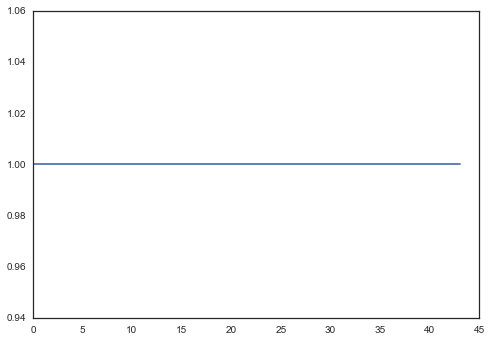

In [249]:
df_new = df_merged.drop(["FIPS","Cases"], axis=1)
X = df_new.values

columns = X.shape[1]
for column in np.arange(columns):
    mean_temp = X[:,column].mean()
    std_temp = X[:,column].std()
    X[:,column] = (X[:,column]-mean_temp)/std_temp

plt.plot((np.std(X, axis=0)))

In [250]:
X.shape

(3060, 44)

In [251]:
pca = PCA(n_components=44)
pca.fit(X)
pca.explained_variance_ratio_

array([  2.71471833e-01,   1.93126728e-01,   9.41874371e-02,
         7.34177818e-02,   6.37037960e-02,   4.55901148e-02,
         4.18911937e-02,   3.24264619e-02,   2.81601391e-02,
         2.53423284e-02,   1.81447087e-02,   1.68177787e-02,
         1.33659747e-02,   1.23251154e-02,   1.13496034e-02,
         9.37119556e-03,   8.75033900e-03,   7.28550044e-03,
         6.65812941e-03,   4.61285242e-03,   3.93166781e-03,
         3.90653487e-03,   3.11619184e-03,   2.67184329e-03,
         2.03751918e-03,   1.62668155e-03,   1.45365972e-03,
         1.20469458e-03,   9.01412335e-04,   2.93358317e-04,
         2.28882093e-04,   1.66288698e-04,   1.65289108e-04,
         1.41983923e-04,   7.60248342e-05,   5.31388748e-05,
         1.38378829e-05,   7.79496823e-06,   3.90935243e-06,
         2.68410654e-07,   2.95117185e-09,   2.04230644e-09,
         1.86317230e-09,   6.14274685e-33])

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


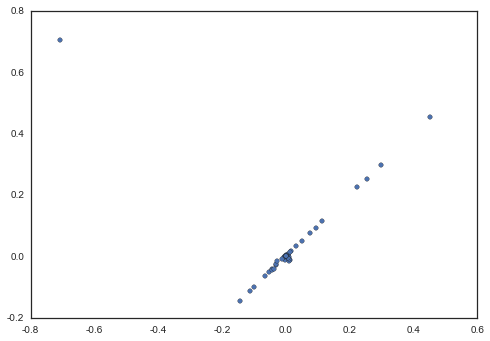

In [252]:
plt.scatter(pca.components_[:,0], pca.components_[:,1])

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


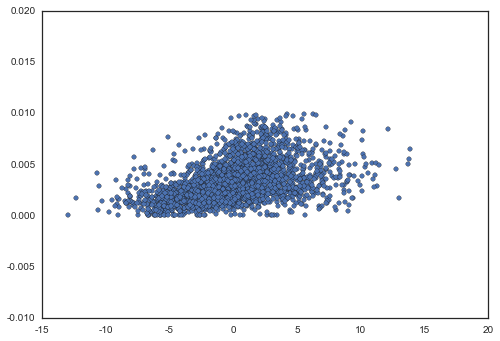

In [253]:
X_trans = pca.transform(X)
Y = df_merged["Cases"]/df_merged["Population"]
plt.scatter(X_trans[:,0],Y)

### Linear regression

In [326]:
from sklearn import linear_model

In [327]:
df_new = df_merged.drop(["FIPS","Cases"], axis=1)

In [328]:
df_new.head()

,Population,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,hd01vd01,d002,d014,d019,d024,d029
0,55246,54571,21.8,7.9,5.6,5.8,6.1,7.6,7.5,15.0,10.7,12.0,37.0,48.7,51.3,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,0.8,74.5,34.9,56.2,25.3,25.5,2.68,3.13,75.4,24.6,52475,0.562138,0.003017,0.020029,0.002868,0.017704
1,195540,182265,19.0,6.4,5.2,5.6,5.9,6.3,6.6,14.8,13.5,16.9,41.1,48.9,51.1,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,1.3,69.9,28.0,54.5,19.9,30.1,2.46,2.93,72.5,27.5,50183,0.545409,0.002747,0.023886,0.003444,0.020292
2,27076,27457,18.0,6.3,6.5,7.3,6.6,6.6,6.6,14.7,13.2,14.3,39.0,53.1,46.9,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,11.6,68.4,27.4,43.7,14.4,31.6,2.47,3.01,66.8,33.2,35634,0.437169,0.002342,0.019348,0.003666,0.022200
3,22512,22915,18.4,6.7,6.5,7.0,7.2,7.6,7.1,14.8,11.9,12.6,37.8,53.7,46.3,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,9.7,72.3,29.5,52.5,20.1,27.7,2.60,3.09,75.6,24.4,37984,0.524582,0.001886,0.020244,0.002012,0.020370
4,57872,57322,20.2,7.0,5.4,6.0,6.0,6.8,7.0,14.1,12.6,14.6,39.0,49.5,50.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,0.9,75.0,31.1,60.6,24.1,25.0,2.63,3.07,80.6,19.4,44409,0.606034,0.001946,0.017981,0.003707,0.013440


In [329]:
df_new.shape

(3060, 44)

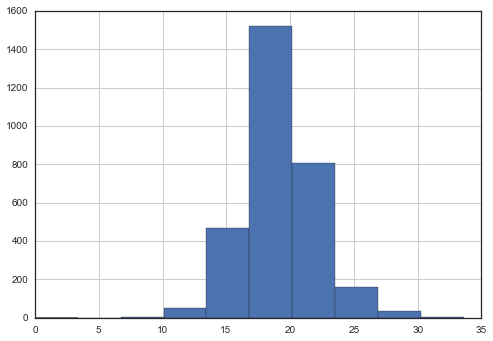

In [330]:
df_new["hd02s002"].hist()

Split data set into training and test data

In [331]:
cutoff = 1

X = df_new[df_merged["Cases"]>cutoff].values
Y = df_merged[df_merged["Cases"]>cutoff].Cases/df_merged[df_merged["Cases"]>cutoff].Population

X_full = df_new.values
Y_full = df_merged.Cases/df_merged.Population

#normalize all columns and the full dataset to the same normalization
columns = X.shape[1]
means = np.zeros(columns)
stds = np.zeros(columns)
for column in np.arange(columns):
    mean_temp = X[:,column].mean()
    std_temp = X[:,column].std()
    means[column] = mean_temp
    stds[column] = std_temp
    X[:,column] = (X[:,column]-mean_temp)/std_temp
    X_full[:,column] = (X_full[:,column]-mean_temp)/std_temp

Ymean = Y_full.mean()
Ystd = Y_full.std()

Y = (Y-Ymean)/Ystd
Y_full = (Y_full-Ymean)/Ystd
    
ones = np.ones(round(0.75*len(X)), dtype=bool)
zeros = np.zeros(len(X)-round(0.75*len(X)), dtype=bool)
training_list = np.hstack((ones, zeros))
np.random.shuffle(training_list)
test_list = np.zeros(len(X),dtype=bool)
test_list = np.array([not i for i in training_list])

X_train = X[training_list]
X_test = X[test_list]
Y_train = Y[training_list]
Y_test = Y[test_list]

len(X), len(X_train), len(X_test)

(2975, 2231, 744)

In [332]:
X.shape, Y.shape

((2975, 44), (2975,))

In [333]:
Y_test.describe()

count    744.000000
mean       0.023869
std        1.010695
min       -1.721385
25%       -0.684513
50%       -0.247165
75%        0.435678
max        3.470122
dtype: float64

In [334]:
#X_weights = df_merged.values
#X_train_weights = X_weights[training_list]
weights = 1 #X_train_weights[:,2]
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train, sample_weight=weights)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [335]:
print(regr.coef_)

[ -1.16231542e+00   1.20621542e+00  -1.49502808e-02  -7.09473157e-02
   9.32647379e-03  -6.17765537e-02  -3.04812366e-02  -4.79414462e-02
  -1.16801374e-01   3.05769321e-02  -4.02642142e-02  -1.54585866e-02
  -4.94055362e-01  -3.80031897e-02   3.80031897e-02   2.94388201e-01
   6.34710501e-01   1.89475935e-01   3.38649601e-02  -2.55741451e-02
   1.36653478e-01   1.41656507e-01  -1.45300933e+01   1.69986012e-01
  -4.30252359e-01  -6.80371381e-01  -4.50912027e-02  -2.22615032e-01
  -1.48609419e+01   3.34069043e-01   8.98130213e-01  -5.82521274e-01
  -9.24681526e-01  -3.34070090e-01  -1.08218072e+00   1.01327053e+00
   2.61005618e+01   2.61826649e+01   1.18497617e-01   8.12403420e-01
  -6.65835538e-03  -2.26581852e-02  -2.54250580e-02   5.23973323e-02]


In [336]:
1.0-np.sum((regr.predict(X_full)-Y_full)**2)/np.sum((Y_full-np.mean(Y_full))**2)

0.70007487443543703

/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


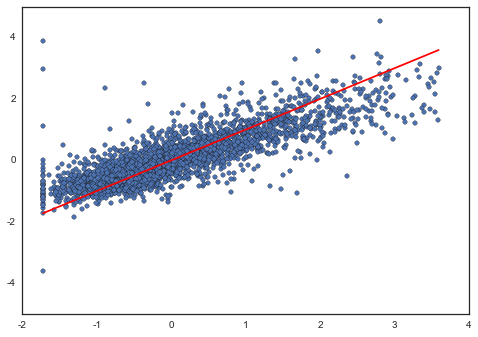

In [337]:
plt.scatter(Y_full,regr.predict(X_full))
plt.plot(np.linspace(Y_full.min(),Y_full.max(),num=10),np.linspace(Y_full.min(),Y_full.max(),num=10),color='red')

In [338]:
print('Variance score: %.5f\t(%.5f)' % (regr.score(X_test, Y_test), regr.score(X_full, Y_full)))

Variance score: 0.68361	(0.70007)


#### Some results from playing around with linear regression:

Baseline result: 0.71849 (0.70180) (no weights, full data set)

0.69579	(0.67342) (no weights, cut-off at population of 10000)

0.74215	(0.54436) (no weights, cut-off at 100 cases)

## Ridge regression

In [341]:
from sklearn import linear_model

In [342]:
rregr = linear_model.Ridge(alpha=0.5)
rregr.fit(X_train, Y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [343]:
print('Variance score: %.5f\t(%.5f)' % (rregr.score(X_test, Y_test), rregr.score(X_full, Y_full)))

Variance score: 0.68284	(0.69991)


## Extra Trees Regression

In [344]:
from sklearn.ensemble import ExtraTreesRegressor

In [345]:
clf = ExtraTreesRegressor(n_estimators=250, bootstrap=True, oob_score=True, max_features='sqrt')
clf.fit(X_train, Y_train)

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=250, n_jobs=1, oob_score=True, random_state=None,
          verbose=0, warm_start=False)

In [346]:
print('Variance score: %.5f\t(%.5f)\nOut of bag error score: %.5f' % (clf.score(X_test, Y_test), clf.score(X_full, Y_full),clf.oob_score_))

Variance score: 0.69191	(0.86219)
Out of bag error score: 0.70269


## Ada Boost Regressor

In [347]:
from sklearn.ensemble import AdaBoostRegressor

In [348]:
clf = AdaBoostRegressor(n_estimators=500, learning_rate=0.01, loss='linear')
clf.fit(X_train, Y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
         n_estimators=500, random_state=None)

In [349]:
print('Variance score: %.5f\t(%.5f)' % (clf.score(X_test, Y_test), clf.score(X_full, Y_full)))

Variance score: 0.61839	(0.64786)


## Bagging regressor

In [350]:
from sklearn.ensemble import BaggingRegressor

In [351]:
clf = BaggingRegressor(n_estimators=250, bootstrap=True, oob_score=True, max_features=20)
clf.fit(X_train, Y_train)

BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=20, max_samples=1.0,
         n_estimators=250, n_jobs=1, oob_score=True, random_state=None,
         verbose=0, warm_start=False)

In [352]:
print('Variance score: %.5f\t(%.5f)\nOut of bag error score: %.5f' % (clf.score(X_test, Y_test), clf.score(X_full, Y_full),1-clf.oob_score_))

Variance score: 0.69255	(0.84947)
Out of bag error score: 0.29300


## Gradient Boosting Regressor

In [353]:
from sklearn.ensemble import GradientBoostingRegressor

In [354]:
clf = GradientBoostingRegressor(n_estimators=250, max_features=10,max_depth=5)
clf.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=5, max_features=10, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=250,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [355]:
print('Variance score: %.5f\t(%.5f)' % (clf.score(X_test, Y_test), clf.score(X_full, Y_full)))

Variance score: 0.68976	(0.85776)


/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


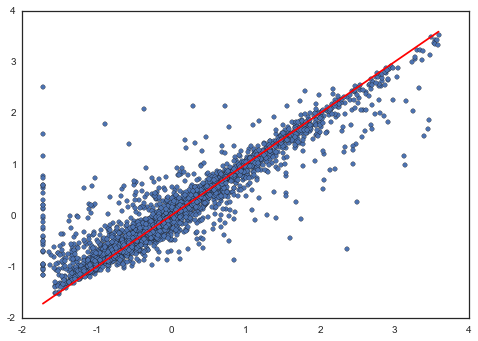

In [356]:
plt.scatter(Y_full,clf.predict(X_full))
plt.plot(np.linspace(Y_full.min(),Y_full.max(),num=10),np.linspace(Y_full.min(),Y_full.max(),num=10),color='red')

In [357]:
import pickle

In [358]:
with open("../data/gradientboosting_params.pickle", "wb") as myfile:
    pickle.dump(clf, myfile)

In [359]:
with open("../data/Ymean.pickle", "wb") as myfile:
    pickle.dump(Ymean, myfile)

In [360]:
with open("../data/Ystd.pickle", "wb") as myfile:
    pickle.dump(Ystd, myfile)

In [361]:
with open("../data/Xmeans.pickle", "wb") as myfile:
    pickle.dump(means, myfile)

In [362]:
with open("../data/Xstds.pickle", "wb") as myfile:
    pickle.dump(stds, myfile)

## Random forest

In [108]:
from sklearn.ensemble import RandomForestRegressor

In [109]:
df_merged = pd.read_csv("../data/chlamydia_cdc_census.csv")
df_new = df_merged.drop(["FIPS","Cases"], axis=1)

In [110]:
df_new.head()

,Population,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,hd01vd01,d002,d014,d019,d024,d029
0,55246,4.736962,21.8,7.9,5.6,5.8,6.1,7.6,7.5,15.0,10.7,12.0,37.0,48.7,51.3,78.5,17.7,0.4,0.9,0.1,1.6,2.4,99.2,37.1,20.8,31.8,23.6,6.1,0.8,74.5,34.9,56.2,25.3,25.5,2.68,3.13,75.4,24.6,52475,0.562138,0.003017,0.020029,0.002868,0.017704
1,195540,5.260703,19.0,6.4,5.2,5.6,5.9,6.3,6.6,14.8,13.5,16.9,41.1,48.9,51.1,85.7,9.4,0.7,0.7,0.0,1.5,4.4,98.7,40.2,21.9,26.8,20.1,5.6,1.3,69.9,28.0,54.5,19.9,30.1,2.46,2.93,72.5,27.5,50183,0.545409,0.002747,0.023886,0.003444,0.020292
2,27076,4.438653,18.0,6.3,6.5,7.3,6.6,6.6,6.6,14.7,13.2,14.3,39.0,53.1,46.9,48.0,46.9,0.4,0.4,0.1,0.9,5.1,88.4,35.8,15.6,25.7,17.7,7.8,11.6,68.4,27.4,43.7,14.4,31.6,2.47,3.01,66.8,33.2,35634,0.437169,0.002342,0.019348,0.003666,0.022200
3,22512,4.360120,18.4,6.7,6.5,7.0,7.2,7.6,7.1,14.8,11.9,12.6,37.8,53.7,46.3,75.8,22.0,0.3,0.1,0.1,0.9,1.8,90.3,34.7,18.2,26.8,18.7,7.5,9.7,72.3,29.5,52.5,20.1,27.7,2.60,3.09,75.6,24.4,37984,0.524582,0.001886,0.020244,0.002012,0.020370
4,57872,4.758321,20.2,7.0,5.4,6.0,6.0,6.8,7.0,14.1,12.6,14.6,39.0,49.5,50.5,92.6,1.3,0.5,0.2,0.1,1.2,8.1,99.1,37.6,22.8,29.2,21.3,6.4,0.9,75.0,31.1,60.6,24.1,25.0,2.63,3.07,80.6,19.4,44409,0.606034,0.001946,0.017981,0.003707,0.013440


In [111]:
cutoff = 1

X = df_new[df_merged["Cases"]>cutoff].values
Y = df_merged[df_merged["Cases"]>cutoff].Cases/df_merged[df_merged["Cases"]>cutoff].Population

X_full = df_new.values
Y_full = df_merged.Cases/df_merged.Population

#normalize all columns and the full dataset to the same normalization
columns = X.shape[1]
means = np.zeros(columns)
stds = np.zeros(columns)
for column in np.arange(columns):
    mean_temp = X[:,column].mean()
    std_temp = X[:,column].std()
    means[column] = mean_temp
    stds[column] = std_temp
    X[:,column] = (X[:,column]-mean_temp)/std_temp
    X_full[:,column] = (X_full[:,column]-mean_temp)/std_temp


Ymean = Y_full.mean()
Ystd = Y_full.std()

Y = (Y-Ymean)/Ystd
Y_full = (Y_full-Ymean)/Ystd


ones = np.ones(round(0.75*len(X)), dtype=bool)
zeros = np.zeros(len(X)-round(0.75*len(X)), dtype=bool)
training_list = np.hstack((ones, zeros))
np.random.shuffle(training_list)
test_list = np.zeros(len(X),dtype=bool)
test_list = np.array([not i for i in training_list])

X_train = X[training_list]
X_test = X[test_list]
Y_train = Y[training_list]
Y_test = Y[test_list]

In [112]:
clf = RandomForestRegressor(n_estimators=250, oob_score=True, max_features='sqrt')
clf.fit(X_full, Y_full)
#clf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

In [113]:
print('Variance score: %.5f\t(%.5f)\nOut of bag error score: %.5f' % (clf.score(X_test, Y_test), clf.score(X_full, Y_full),clf.oob_score_))

Variance score: 0.95733	(0.95959)
Out of bag error score: 0.70238


/Users/akuepper/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


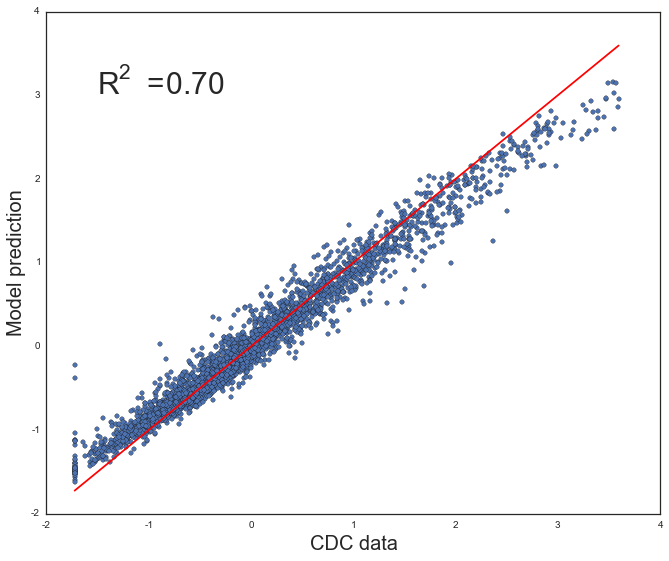

In [124]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

ax.text(-1.5, 3, r'$R^2 = $%.2f'%(clf.oob_score_), fontsize=30)


ax.set_xlabel("CDC data", fontsize=20)
ax.set_ylabel("Model prediction", fontsize=20)

ax = plt.scatter(Y_full,clf.predict(X_full))
ax2 = plt.plot(np.linspace(Y_full.min(),Y_full.max(),10),np.linspace(Y_full.min(),Y_full.max(),10),color='red')

plt.savefig('../graphics/cross-correlation.png', bbox_inches='tight', dpi=150)

In [469]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(clf, X_full, Y_full)

In [470]:
scores.mean()

0.67479433835826352

/Users/akuepper/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/akuepper/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/akuepper/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/akuepper/anaconda/lib/python3.5/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estim

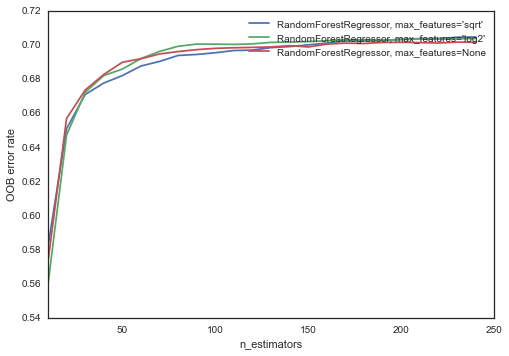

In [471]:
from collections import OrderedDict
RANDOM_STATE = 123
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=False, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(warm_start=False, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=False, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 250

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators,10):
        clf.set_params(n_estimators=i)
        clf.fit(X_full, Y_full)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="lower right")
plt.show()

In [383]:
print(np.vstack((np.arange(len(clf.feature_importances_)), clf.feature_importances_)).T)

[[  0.00000000e+00   1.46104488e-02]
 [  1.00000000e+00   1.27619343e-02]
 [  2.00000000e+00   1.41775842e-02]
 [  3.00000000e+00   9.52583409e-03]
 [  4.00000000e+00   4.45219456e-02]
 [  5.00000000e+00   2.17734914e-02]
 [  6.00000000e+00   7.05287470e-03]
 [  7.00000000e+00   8.07249580e-03]
 [  8.00000000e+00   1.13150722e-02]
 [  9.00000000e+00   1.66499789e-02]
 [  1.00000000e+01   1.23870111e-02]
 [  1.10000000e+01   1.15722642e-02]
 [  1.20000000e+01   2.31949764e-02]
 [  1.30000000e+01   1.74387185e-02]
 [  1.40000000e+01   1.60070475e-02]
 [  1.50000000e+01   1.21699725e-01]
 [  1.60000000e+01   8.01340330e-02]
 [  1.70000000e+01   9.43806937e-03]
 [  1.80000000e+01   6.45144343e-03]
 [  1.90000000e+01   2.48503654e-03]
 [  2.00000000e+01   1.41537817e-02]
 [  2.10000000e+01   1.10899054e-02]
 [  2.20000000e+01   7.92571316e-03]
 [  2.30000000e+01   9.26737570e-03]
 [  2.40000000e+01   1.00514812e-01]
 [  2.50000000e+01   1.09418247e-02]
 [  2.60000000e+01   9.39802364e-03]
 

0       "hd01s001",  #population
1       "hd02s002",  #under 5 yrs
2       "hd02s003",  #5-9 yrs 
3       "hd02s004",  #10-14
4       "hd02s005",  #15-19
5       "hd02s006",  #20-24
6       "hd02s007",  #25-29
7       "hd02s008",  #30-34
8       "hd02s009",  #35-39
9       "hd02s010",  #40-44
10      "hd02s011",  #45-49
11      "hd02s012",  #50-54
12      "hd02s013",  #55-59
13      "hd02s014",  #60-64
14      "hd02s015",  #65-69
15      "hd02s016",  #70-74
16      "hd02s017",  #75-79
17      "hd02s018",  #80-84
18      "hd02s019",  #85 and over
19      "hd01s020",  #median age
20      "hd02s026",  #male percent
21      "hd02s051",  #female percent
22      "hd02s078",  #white
23      "hd02s079",  #black
24      "hd02s080",  #native
25      "hd02s081",  #asian
26      "hd02s089",  #pacific
27      "hd02s095",  #two or more
28      "hd02s107",  #hispanic
29      "hd02s131",  #in households
30      "hd02s132",  #householder
31      "hd02s133",  #spouse
32      "hd02s134",  #child
33      "hd02s135",  #child w own child under 18
34      "hd02s136",  #other relatives
35      "hd02s143",  #in group quarters
36      "hd02s151",  #family households
37      "hd02s152",  #family households w own child under 18
38      "hd02s153",  #husband-wife family
39      "hd02s154",  #husband-wife family w own child under 18
40      "hd02s159",  #nonfamily households
41      "hd01s167",  #average household size
42      "hd01s168",  #average family size
43      "hd02s181",  #owner occupied housing units
44      "hd02s184",  #renter occupied housing units
45      "hd01vd01",  #median income
46      "d001",      #Total households
47      "d002",      #Husband-wife households
48      "d014",      #Unmarried-partner households: - Male householder and male partner
49      "d019",      #Unmarried-partner households: - Male householder and female partner
50      "d024",      #Unmarried-partner households: - Female householder and female partner
51      "d029"       #Unmarried-partner households: - Female householder and male partner

Most important features: percentage of white people and percentage of people being spouse

Save model parameters for use in web app:

In [384]:
import pickle

In [385]:
with open("../data/randomforest_params.pickle", "wb") as myfile:
    pickle.dump(clf, myfile)

In [386]:
with open("../data/Ymean.pickle", "wb") as myfile:
    pickle.dump(Ymean, myfile)

In [387]:
with open("../data/Ystd.pickle", "wb") as myfile:
    pickle.dump(Ystd, myfile)

In [388]:
with open("../data/Xmeans.pickle", "wb") as myfile:
    pickle.dump(means, myfile)

In [389]:
with open("../data/Xstds.pickle", "wb") as myfile:
    pickle.dump(stds, myfile)

In [390]:
deployed_model = pickle.load(open('../data/randomforest_params.pickle', "rb" ))

In [391]:
print('Variance score: %.5f\t(%.5f)' % (deployed_model.score(X_test, Y_test), deployed_model.score(X_full, Y_full)))

Variance score: 0.96093	(0.96013)


## Suport Vector Regression

In [604]:
from sklearn.svm import SVR

In [605]:
svr_rbf = SVR(kernel='rbf', C=15, gamma=0.0001, epsilon=0.0005, tol=0.00001)
#svr_lin = SVR(kernel='linear', C=1, epsilon=0.001)
#svr_poly = SVR(kernel='poly', C=1, degree=2, epsilon=0.001)
svr_rbf.fit(X_train, Y_train)
#svr_lin.fit(X_train, Y_train)
#svr_poly.fit(X_train, Y_train)
#print('Variance score:\n\t%.5f\t(rbf)\n\t%.5f\t(lin)\n\t%.5f\t(poly)' % (svr_rbf.score(X_train, Y_train), svr_lin.score(X_train, Y_train),svr_poly.score(X_train, Y_train)))
print('Variance score:\n\t%.5f\t(rbf)' % (svr_rbf.score(X_test, Y_test)))

Variance score:
	0.68121	(rbf)


In [606]:
#svr_rbf = SVR(kernel='rbf', C=10, gamma=0.0001, epsilon=0.0001)
#svr_lin = SVR(kernel='linear', C=1, epsilon=0.001)
svr_poly = SVR(kernel='poly', C=15, gamma=0.0001, degree=2, epsilon=0.0001, tol=0.00001, max_iter=1000000)
#svr_rbf.fit(X_train, Y_train)
#svr_lin.fit(X_train, Y_train)
svr_poly.fit(X_train, Y_train)
#print('Variance score:\n\t%.5f\t(rbf)\n\t%.5f\t(lin)\n\t%.5f\t(poly)' % (svr_rbf.score(X_train, Y_train), svr_lin.score(X_train, Y_train),svr_poly.score(X_train, Y_train)))
print('Variance score:\n\t%.5f\t(poly)' % (svr_poly.score(X_test, Y_test)))

Variance score:
	-0.03998	(poly)


In [156]:
svr_lin = SVR(kernel='linear', C=15, epsilon=0.0001, tol=0.00001, max_iter=100000)
svr_lin.fit(X_train, Y_train)
print('Variance score:\n\t%.5f\t(linear)' % (svr_lin.score(X_test, Y_test)))

Variance score:
	-0.68827	(linear)


/Users/akuepper/anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


## Census data on ZIP code level

In [428]:
df_census_zip = pd.read_csv("../data/census/DEC_10_general_zipcode.csv", header=0, skiprows={1})

In [429]:
df_census_zip.head()

,GEO.id,GEO.id2,GEO.display-label,HD01_S001,HD02_S001,HD01_S002,HD02_S002,HD01_S003,HD02_S003,HD01_S004,HD02_S004,HD01_S005,HD02_S005,HD01_S006,HD02_S006,HD01_S007,HD02_S007,HD01_S008,HD02_S008,HD01_S009,HD02_S009,HD01_S010,HD02_S010,HD01_S011,HD02_S011,HD01_S012,HD02_S012,HD01_S013,HD02_S013,HD01_S014,HD02_S014,HD01_S015,HD02_S015,HD01_S016,HD02_S016,HD01_S017,HD02_S017,HD01_S018,HD02_S018,HD01_S019,HD02_S019,HD01_S020,HD02_S020,HD01_S021,HD02_S021,HD01_S022,HD02_S022,HD01_S023,HD02_S023,HD01_S024,HD02_S024,HD01_S025,HD02_S025,HD01_S026,HD02_S026,HD01_S027,HD02_S027,HD01_S028,HD02_S028,HD01_S029,HD02_S029,HD01_S030,HD02_S030,HD01_S031,HD02_S031,HD01_S032,HD02_S032,HD01_S033,HD02_S033,HD01_S034,HD02_S034,HD01_S035,HD02_S035,HD01_S036,HD02_S036,HD01_S037,HD02_S037,HD01_S038,HD02_S038,HD01_S039,HD02_S039,HD01_S040,HD02_S040,HD01_S041,HD02_S041,HD01_S042,HD02_S042,HD01_S043,HD02_S043,HD01_S044,HD02_S044,HD01_S045,HD02_S045,HD01_S046,HD02_S046,HD01_S047,HD02_S047,HD01_S048,HD02_S048,HD01_S049,...,HD01_S137,HD02_S137,HD01_S138,HD02_S138,HD01_S139,HD02_S139,HD01_S140,HD02_S140,HD01_S141,HD02_S141,HD01_S142,HD02_S142,HD01_S143,HD02_S143,HD01_S144,HD02_S144,HD01_S145,HD02_S145,HD01_S146,HD02_S146,HD01_S147,HD02_S147,HD01_S148,HD02_S148,HD01_S149,HD02_S149,HD01_S150,HD02_S150,HD01_S151,HD02_S151,HD01_S152,HD02_S152,HD01_S153,HD02_S153,HD01_S154,HD02_S154,HD01_S155,HD02_S155,HD01_S156,HD02_S156,HD01_S157,HD02_S157,HD01_S158,HD02_S158,HD01_S159,HD02_S159,HD01_S160,HD02_S160,HD01_S161,HD02_S161,HD01_S162,HD02_S162,HD01_S163,HD02_S163,HD01_S164,HD02_S164,HD01_S165,HD02_S165,HD01_S166,HD02_S166,HD01_S167,HD02_S167,HD01_S168,HD02_S168,HD01_S169,HD02_S169,HD01_S170,HD02_S170,HD01_S171,HD02_S171,HD01_S172,HD02_S172,HD01_S173,HD02_S173,HD01_S174,HD02_S174,HD01_S175,HD02_S175,HD01_S176,HD02_S176,HD01_S177,HD02_S177,HD01_S178,HD02_S178,HD01_S179,HD02_S179,HD01_S180,HD02_S180,HD01_S181,HD02_S181,HD01_S182,HD02_S182,HD01_S183,HD02_S183,HD01_S184,HD02_S184,HD01_S185,HD02_S185,HD01_S186,HD02_S186
0,8600000US00601,601,ZCTA5 00601,18570,100,1142,6.1,1245,6.7,1440,7.8,1558,8.4,1302,7,1281,6.9,1139,6.1,1043,5.6,1231,6.6,1235,6.7,1224,6.6,1204,6.5,1063,5.7,843,4.5,604,3.3,443,2.4,283,1.5,290,1.6,35.9,( X ),14436,77.7,13806,74.3,12896,69.4,3116,16.8,2463,13.3,9078,48.9,569,3.1,643,3.5,716,3.9,847,4.6,665,3.6,614,3.3,528,2.8,492,2.6,582,3.1,597,3.2,597,3.2,568,3.1,525,2.8,396,2.1,283,1.5,221,1.2,126,0.7,109,0.6,34.5,( X ),6984,37.6,6644,35.8,6163,33.2,1449,...,538,2.9,188,1,447,2.4,27,0.1,34,0.2,357,1.9,62,0.3,57,0.3,27,0.1,30,0.2,5,0,2,0,3,0,6525,100,5078,77.8,2261,34.7,3415,52.3,1465,22.5,336,5.1,171,2.6,1327,20.3,625,9.6,1447,22.2,1323,20.3,667,10.2,214,3.3,656,10.1,361,5.5,2579,39.5,1889,29,2.84,( X ),3.27,( X ),7744,100,6525,84.3,1219,15.7,222,2.9,15,0.2,36,0.5,39,0.5,312,4,595,7.7,0.8,( X ),9.4,( X ),6525,100,4392,67.3,12392,( X ),2.82,( X ),2133,32.7,6116,( X ),2.87,( X )
1,8600000US00602,602,ZCTA5 00602,41520,100,2291,5.5,2488,6,3028,7.3,3264,7.9,3007,7.2,2635,6.3,2793,6.7,2557,6.2,2965,7.1,3120,7.5,3028,7.3,2792,6.7,2368,5.7,1844,4.4,1380,3.3,986,2.4,546,1.3,428,1,37.5,( X ),33034,79.6,31696,76.3,29805,71.8,6642,16,5184,12.5,20396,49.1,1173,2.8,1271,3.1,1524,3.7,1647,4,1514,3.6,1299,3.1,1380,3.3,1286,3.1,1413,3.4,1497,3.6,1447,3.5,1370,3.3,1138,2.7,913,2.2,669,1.6,422,1,246,0.6,187,0.5,36.6,( X ),16079,38.7,15402,37.1,14441,34.8,3125,...,1128,2.7,341,0.8,853,2.1,38,0.1,63,0.2,669,1.6,71,0.2,12,0,12,0,0,0,59,0.1,31,0.1,28,0.1,15002,100,11646,77.6,4906,32.7,8272,55.1,3397,22.6,766,5.1,311,2.1,2608,17.4,1198,8,3356,22.4,3071,20.5,1573,10.5,453,3,1498,10,733,4.9,5635,37.6,3891,25.9,2.76,( X ),3.20,( X ),18073,100,15002,83,3071,17,466,2.6,43,0.2,230,1.3,80,0.4,799,4.4,1453,8,1.9,( X ),12,( X ),15002,100,11620,77.5,32580,( X ),2.80,( X ),3382,22.5,8869,( X ),2.62,( X )
2,8600000US00603,603,ZCTA5 00603,54689,100,3245,5.9,3439,6.3,3810,7,3961,7.2,3584,6.6,3510,6.4,3566,6.5,3529,6.5,3444,6.3,3475,6.4,3524,6.4,3372,6.2,3619,6.6,2947,5.4,2228,4.1,1588,2.9,101

In [430]:
columnnames = list(df_census_zip.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    #print(columnname_wo_specialcharacters.lower())
    df_census_zip.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)


In [431]:
df_census_zip_clean = df_census_zip.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_zip_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid               object
geoid2               int64
geodisplaylabel     object
hd01s001             int64
hd02s001           float64
hd01s002             int64
hd02s002           float64
hd01s003             int64
hd02s003           float64
hd01s004             int64
hd02s004           float64
hd01s005             int64
hd02s005           float64
hd01s006             int64
hd02s006           float64
hd01s007             int64
hd02s007           float64
hd01s008             int64
hd02s008           float64
hd01s009             int64
hd02s009           float64
hd01s010             int64
hd02s010           float64
hd01s011             int64
hd02s011           float64
hd01s012             int64
hd02s012           float64
hd01s013             int64
hd02s013           float64
hd01s014             int64
                    ...   
hd01s172             int64
hd02s172           float64
hd01s173             int64
hd02s173           float64
hd01s174             int64
hd02s174           float64
h

In [432]:
df_census_zip_clean.describe()

,geoid2,hd01s001,hd02s001,hd01s002,hd02s002,hd01s003,hd02s003,hd01s004,hd02s004,hd01s005,hd02s005,hd01s006,hd02s006,hd01s007,hd02s007,hd01s008,hd02s008,hd01s009,hd02s009,hd01s010,hd02s010,hd01s011,hd02s011,hd01s012,hd02s012,hd01s013,hd02s013,hd01s014,hd02s014,hd01s015,hd02s015,hd01s016,hd02s016,hd01s017,hd02s017,hd01s018,hd02s018,hd01s019,hd02s019,hd01s020,hd01s021,hd02s021,hd01s022,hd02s022,hd01s023,hd02s023,hd01s024,hd02s024,hd01s025,hd02s025,hd01s026,hd02s026,hd01s027,hd02s027,hd01s028,hd02s028,hd01s029,hd02s029,hd01s030,hd02s030,hd01s031,hd02s031,hd01s032,hd02s032,hd01s033,hd02s033,hd01s034,hd02s034,hd01s035,hd02s035,hd01s036,hd02s036,hd01s037,hd02s037,hd01s038,hd02s038,hd01s039,hd02s039,hd01s040,hd02s040,hd01s041,hd02s041,hd01s042,hd02s042,hd01s043,hd02s043,hd01s044,hd02s044,hd01s045,hd01s046,hd02s046,hd01s047,hd02s047,hd01s048,hd02s048,hd01s049,hd02s049,hd01s050,hd02s050,hd01s051,...,hd01s133,hd02s133,hd01s134,hd02s134,hd01s135,hd02s135,hd01s136,hd02s136,hd01s137,hd02s137,hd01s138,hd02s138,hd01s139,hd02s139,hd01s140,hd02s140,hd01s141,hd02s141,hd01s142,hd02s142,hd01s143,hd02s143,hd01s144,hd02s144,hd01s145,hd02s145,hd01s146,hd02s146,hd01s147,hd02s147,hd01s148,hd02s148,hd01s149,hd02s149,hd01s150,hd02s150,hd01s151,hd02s151,hd01s152,hd02s152,hd01s153,hd02s153,hd01s154,hd02s154,hd01s155,hd02s155,hd01s156,hd02s156,hd01s157,hd02s157,hd01s158,hd02s158,hd01s159,hd02s159,hd01s160,hd02s160,hd01s161,hd02s161,hd01s162,hd02s162,hd01s163,hd02s163,hd01s164,hd02s164,hd01s165,hd02s165,hd01s166,hd02s166,hd01s167,hd01s168,hd01s169,hd02s169,hd01s170,hd02s170,hd01s171,hd02s171,hd01s172,hd02s172,hd01s173,hd02s173,hd01s174,hd02s174,hd01s175,hd02s175,hd01s176,hd02s176,hd01s177,hd02s177,hd01s178,hd01s179,hd01s180,hd02s180,hd01s181,hd02s181,hd01s182,hd01s183,hd01s184,hd02s184,hd01s185,hd01s186
count,33120.000000,33120.000000,32976,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,...,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32976.000000,33120.000000,32803,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,32803.000000,33120.000000,3312

In [433]:
df_census_zip_subset = df_census_zip_clean[["geoid2",
                                    "hd01s001",  #population
                                    "hd02s002",  #under 5 yrs
                                    "hd02s003",  #5-9 yrs 
                                    "hd02s004",  #10-14
                                    "hd02s005",  #15-19
                                    "hd02s006",  #20-24
                                    "hd02s007",  #25-29
                                    "hd02s008",  #30-34
                                    "hd02s009",  #35-39
                                    "hd02s010",  #40-44
                                    "hd02s011",  #45-49
                                    "hd02s012",  #50-54
                                    "hd02s013",  #55-59
                                    "hd02s014",  #60-64
                                    "hd02s015",  #65-69
                                    "hd02s016",  #70-74
                                    "hd02s017",  #75-79
                                    "hd02s018",  #80-84
                                    "hd02s019",  #85 and over
                                    "hd01s020",  #median age
                                    "hd02s026",  #male percent
                                    "hd02s051",  #female percent
                                    "hd02s078",  #white
                                    "hd02s079",  #black
                                    "hd02s080",  #native
                                    "hd02s081",  #asian
                                    "hd02s089",  #pacific
                                    "hd02s095",  #two or more
                                    "hd02s107",  #hispanic
                                    "hd02s131",  #in households
                                    "hd02s132",  #householder
                                    "hd02s133",  #spouse
                                    "hd02s134",  #child
                                    "hd02s135",  #child w own child under 18
                                    "hd02s136",  #other relatives
                                    "hd02s143",  #in group quarters
                                    "hd02s151",  #family households
                                    "hd02s152",  #family households w own child under 18
                                    "hd02s153",  #husband-wife family
                                    "hd02s154",  #husband-wife family w own child under 18
                                    "hd02s159",  #nonfamily households
                                    "hd01s167",  #average household size
                                    "hd01s168",  #average family size
                                    "hd02s181",  #owner occupied housing units
                                    "hd02s184"   #renter occupied housing units
                                   ]].copy()
df_census_zip_subset.head()

,geoid2,hd01s001,hd02s002,hd02s003,hd02s004,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s012,hd02s013,hd02s014,hd02s015,hd02s016,hd02s017,hd02s018,hd02s019,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184
0,601,18570,6.1,6.7,7.8,8.4,7.0,6.9,6.1,5.6,6.6,6.7,6.6,6.5,5.7,4.5,3.3,2.4,1.5,1.6,35.9,48.9,51.1,93.1,3.1,0.4,0.0,0.0,1.3,99.5,99.7,35.1,18.4,37.5,22.5,6.2,0.3,77.8,34.7,52.3,22.5,22.2,2.84,3.27,67.3,32.7
1,602,41520,5.5,6.0,7.3,7.9,7.2,6.3,6.7,6.2,7.1,7.5,7.3,6.7,5.7,4.4,3.3,2.4,1.3,1.0,37.5,49.1,50.9,86.7,5.3,0.3,0.1,0.0,2.4,99.4,99.8,36.1,19.9,35.6,20.8,6.1,0.2,77.6,32.7,55.1,22.6,22.4,2.76,3.20,77.5,22.5
2,603,54689,5.9,6.3,7.0,7.2,6.6,6.4,6.5,6.5,6.3,6.4,6.4,6.2,6.6,5.4,4.1,2.9,1.8,1.5,38.2,48.6,51.4,82.9,7.6,0.3,0.2,0.0,2.5,98.5,97.9,38.7,17.2,32.9,20.6,6.6,2.1,71.1,29.8,44.4,17.1,28.9,2.53,3.06,64.9,35.1
3,606,6615,6.6,6.2,7.4,7.7,7.8,6.9,6.1,6.0,6.4,6.7,6.9,6.5,6.0,4.5,3.1,2.4,1.3,1.6,36.2,49.4,50.6,88.9,4.7,0.4,0.0,0.1,1.5,99.4,99.8,36.3,18.2,34.9,21.3,7.7,0.2,74.6,31.6,50.0,20.8,25.4,2.75,3.24,72.3,27.7
4,610,29016,5.7,6.1,7.6,7.5,6.4,6.2,6.7,6.7,7.1,6.8,6.6,6.0,6.2,5.0,4.1,2.6,1.5,1.3,38.1,48.6,51.4,82.0,7.2,0.3,0.1,0.0,2.8,99.2,99.6,37.3,18.5,33.8,20.7,7.2,0.4,74.4,31.2,49.6,19.9,25.6,2.67,3.14,77.5,22.5


In [434]:
df_census_zip_subset['hd02s002'] = df_census_zip_subset['hd02s002']+df_census_zip_subset['hd02s003']+df_census_zip_subset['hd02s004'] 
df_census_zip_subset['hd02s011'] = df_census_zip_subset['hd02s011']+df_census_zip_subset['hd02s012'] 
df_census_zip_subset['hd02s013'] = df_census_zip_subset['hd02s013']+df_census_zip_subset['hd02s014'] 
df_census_zip_subset['hd02s015'] = df_census_zip_subset['hd02s015']+df_census_zip_subset['hd02s016']+df_census_zip_subset['hd02s017']+df_census_zip_subset['hd02s018']+df_census_zip_subset['hd02s019']

In [435]:
df_census_zip_combined_subset = df_census_zip_subset[["geoid2",
                                    "hd01s001",  #log10(population)
                                    "hd02s002",  #0-14
                                    "hd02s005",  #15-19
                                    "hd02s006",  #20-24
                                    "hd02s007",  #25-29
                                    "hd02s008",  #30-34
                                    "hd02s009",  #35-39
                                    "hd02s010",  #40-44
                                    "hd02s011",  #45-54
                                    "hd02s013",  #55-64
                                    "hd02s015",  #65+
                                    "hd01s020",  #median age
                                    "hd02s026",  #male percent
                                    "hd02s051",  #female percent
                                    "hd02s078",  #white
                                    "hd02s079",  #black
                                    "hd02s080",  #native
                                    "hd02s081",  #asian
                                    "hd02s089",  #pacific
                                    "hd02s095",  #two or more
                                    "hd02s107",  #hispanic
                                    "hd02s131",  #in households
                                    "hd02s132",  #householder
                                    "hd02s133",  #spouse
                                    "hd02s134",  #child
                                    "hd02s135",  #child w own child under 18
                                    "hd02s136",  #other relatives
                                    "hd02s143",  #in group quarters
                                    "hd02s151",  #family households
                                    "hd02s152",  #family households w own child under 18
                                    "hd02s153",  #husband-wife family
                                    "hd02s154",  #husband-wife family w own child under 18
                                    "hd02s159",  #nonfamily households
                                    "hd01s167",  #average household size
                                    "hd01s168",  #average family size
                                    "hd02s181",  #owner occupied housing units
                                    "hd02s184"   #renter occupied housing units
                                   ]].copy()
df_census_zip_combined_subset.head()

,geoid2,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184
0,601,18570,20.6,8.4,7.0,6.9,6.1,5.6,6.6,13.3,12.2,13.3,35.9,48.9,51.1,93.1,3.1,0.4,0.0,0.0,1.3,99.5,99.7,35.1,18.4,37.5,22.5,6.2,0.3,77.8,34.7,52.3,22.5,22.2,2.84,3.27,67.3,32.7
1,602,41520,18.8,7.9,7.2,6.3,6.7,6.2,7.1,14.8,12.4,12.4,37.5,49.1,50.9,86.7,5.3,0.3,0.1,0.0,2.4,99.4,99.8,36.1,19.9,35.6,20.8,6.1,0.2,77.6,32.7,55.1,22.6,22.4,2.76,3.20,77.5,22.5
2,603,54689,19.2,7.2,6.6,6.4,6.5,6.5,6.3,12.8,12.8,15.7,38.2,48.6,51.4,82.9,7.6,0.3,0.2,0.0,2.5,98.5,97.9,38.7,17.2,32.9,20.6,6.6,2.1,71.1,29.8,44.4,17.1,28.9,2.53,3.06,64.9,35.1
3,606,6615,20.2,7.7,7.8,6.9,6.1,6.0,6.4,13.6,12.5,12.9,36.2,49.4,50.6,88.9,4.7,0.4,0.0,0.1,1.5,99.4,99.8,36.3,18.2,34.9,21.3,7.7,0.2,74.6,31.6,50.0,20.8,25.4,2.75,3.24,72.3,27.7
4,610,29016,19.4,7.5,6.4,6.2,6.7,6.7,7.1,13.4,12.2,14.5,38.1,48.6,51.4,82.0,7.2,0.3,0.1,0.0,2.8,99.2,99.6,37.3,18.5,33.8,20.7,7.2,0.4,74.4,31.2,49.6,19.9,25.6,2.67,3.14,77.5,22.5


In [436]:
df_census_zip_subset.head()

,geoid2,hd01s001,hd02s002,hd02s003,hd02s004,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s012,hd02s013,hd02s014,hd02s015,hd02s016,hd02s017,hd02s018,hd02s019,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184
0,601,18570,20.6,6.7,7.8,8.4,7.0,6.9,6.1,5.6,6.6,13.3,6.6,12.2,5.7,13.3,3.3,2.4,1.5,1.6,35.9,48.9,51.1,93.1,3.1,0.4,0.0,0.0,1.3,99.5,99.7,35.1,18.4,37.5,22.5,6.2,0.3,77.8,34.7,52.3,22.5,22.2,2.84,3.27,67.3,32.7
1,602,41520,18.8,6.0,7.3,7.9,7.2,6.3,6.7,6.2,7.1,14.8,7.3,12.4,5.7,12.4,3.3,2.4,1.3,1.0,37.5,49.1,50.9,86.7,5.3,0.3,0.1,0.0,2.4,99.4,99.8,36.1,19.9,35.6,20.8,6.1,0.2,77.6,32.7,55.1,22.6,22.4,2.76,3.20,77.5,22.5
2,603,54689,19.2,6.3,7.0,7.2,6.6,6.4,6.5,6.5,6.3,12.8,6.4,12.8,6.6,15.7,4.1,2.9,1.8,1.5,38.2,48.6,51.4,82.9,7.6,0.3,0.2,0.0,2.5,98.5,97.9,38.7,17.2,32.9,20.6,6.6,2.1,71.1,29.8,44.4,17.1,28.9,2.53,3.06,64.9,35.1
3,606,6615,20.2,6.2,7.4,7.7,7.8,6.9,6.1,6.0,6.4,13.6,6.9,12.5,6.0,12.9,3.1,2.4,1.3,1.6,36.2,49.4,50.6,88.9,4.7,0.4,0.0,0.1,1.5,99.4,99.8,36.3,18.2,34.9,21.3,7.7,0.2,74.6,31.6,50.0,20.8,25.4,2.75,3.24,72.3,27.7
4,610,29016,19.4,6.1,7.6,7.5,6.4,6.2,6.7,6.7,7.1,13.4,6.6,12.2,6.2,14.5,4.1,2.6,1.5,1.3,38.1,48.6,51.4,82.0,7.2,0.3,0.1,0.0,2.8,99.2,99.6,37.3,18.5,33.8,20.7,7.2,0.4,74.4,31.2,49.6,19.9,25.6,2.67,3.14,77.5,22.5


### Add income data

In [437]:
df_census_acs_zipcodes = pd.read_csv("../data/census/ACS_14_5YR_income_zipcodes.csv", header=0, skiprows={1})

In [438]:
columnnames = list(df_census_acs_zipcodes.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census_acs_zipcodes.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

geoid
geoid2
geodisplaylabel
hd01vd01
hd02vd01


In [439]:
df_census_acs_zipcodes_clean = df_census_acs_zipcodes.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_acs_zipcodes_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid               object
geoid2               int64
geodisplaylabel     object
hd01vd01           float64
hd02vd01           float64
dtype: object

In [440]:
df_census_acs_zipcodes_subset = df_census_acs_zipcodes_clean[["geoid2",
                                    "hd01vd01"  #median income
                                   ]].copy()
df_census_acs_zipcodes_subset.head()

,geoid2,hd01vd01
0,601,10833
1,602,16353
2,603,16323
3,606,14138
4,610,17265


### Add LGBT data

In [441]:
df_census_lgbt_zipcodes = pd.read_csv("../data/census/DEC_10_lgbt_zipcodes.csv", header=0, skiprows={1})

In [442]:
columnnames = list(df_census_lgbt_zipcodes.columns.values)

for columnname in columnnames:
    columnname_wo_specialcharacters = re.sub('[ \-\_\+\=\`\~\{\}\;\:\,\.\<\>\?\/\!\@\#\$\%\^\&\*\(\)\[\]]', '', columnname)
    print(columnname_wo_specialcharacters.lower())
    df_census_lgbt_zipcodes.rename(columns={columnname: columnname_wo_specialcharacters.lower()}, inplace=True)

geoid
geoid2
geodisplaylabel
d001
d002
d003
d004
d005
d006
d007
d008
d009
d010
d011
d012
d013
d014
d015
d016
d017
d018
d019
d020
d021
d022
d023
d024
d025
d026
d027
d028
d029
d030
d031
d032
d033
d034


In [443]:
df_census_lgbt_zipcodes_clean = df_census_lgbt_zipcodes.replace(to_replace='\(r.+\)', value="", regex=True).convert_objects(convert_numeric=True)
df_census_lgbt_zipcodes_clean.dtypes

/Users/akuepper/anaconda/lib/python3.5/site-packages/pandas/core/common.py:449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


geoid              object
geoid2              int64
geodisplaylabel    object
d001                int64
d002                int64
d003                int64
d004                int64
d005                int64
d006                int64
d007                int64
d008                int64
d009                int64
d010                int64
d011                int64
d012                int64
d013                int64
d014                int64
d015                int64
d016                int64
d017                int64
d018                int64
d019                int64
d020                int64
d021                int64
d022                int64
d023                int64
d024                int64
d025                int64
d026                int64
d027                int64
d028                int64
d029                int64
d030                int64
d031                int64
d032                int64
d033                int64
d034                int64
dtype: object

In [444]:
df_census_lgbt_zipcodes_subset = df_census_lgbt_zipcodes_clean[["geoid2",
                                    "d001",  #Total households
                                    "d002",  #Husband-wife households
                                    "d014",  #Unmarried-partner households: - Male householder and male partner
                                    "d019",  #Unmarried-partner households: - Male householder and female partner
                                    "d024",  #Unmarried-partner households: - Female householder and female partner
                                    "d029"   #Unmarried-partner households: - Female householder and male partner
                                   ]].copy()
df_census_lgbt_zipcodes_subset.head()

,geoid2,d001,d002,d014,d019,d024,d029
0,601,6525,3415,6,187,13,151
1,602,15002,8272,29,344,41,255
2,603,21161,9387,33,414,45,540
3,606,2404,1201,6,76,4,51
4,610,10836,5378,20,284,25,328


In [445]:
df_census_lgbt_zipcodes_subset["d002"] = df_census_lgbt_zipcodes_subset["d002"]/df_census_lgbt_zipcodes_subset["d001"]
df_census_lgbt_zipcodes_subset["d014"] = df_census_lgbt_zipcodes_subset["d014"]/df_census_lgbt_zipcodes_subset["d001"]
df_census_lgbt_zipcodes_subset["d019"] = df_census_lgbt_zipcodes_subset["d019"]/df_census_lgbt_zipcodes_subset["d001"]
df_census_lgbt_zipcodes_subset["d024"] = df_census_lgbt_zipcodes_subset["d024"]/df_census_lgbt_zipcodes_subset["d001"]
df_census_lgbt_zipcodes_subset["d029"] = df_census_lgbt_zipcodes_subset["d029"]/df_census_lgbt_zipcodes_subset["d001"]

In [446]:
df_census_lgbt_zipcodes_subset.drop('d001', axis=1, inplace=True)

In [447]:
df_census_lgbt_zipcodes_subset.dtypes

geoid2      int64
d002      float64
d014      float64
d019      float64
d024      float64
d029      float64
dtype: object

### Merge the zipcode data

In [448]:
df_merged_zipcodes = pd.merge(df_census_zip_combined_subset, df_census_acs_zipcodes_subset, left_on='geoid2', right_on='geoid2', how='inner', sort=False).convert_objects(convert_numeric=True)

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [449]:
df_merged_zipcodes2 = pd.merge(df_merged_zipcodes, df_census_lgbt_zipcodes_subset, left_on='geoid2', right_on='geoid2', how='inner', sort=False).convert_objects(convert_numeric=True)

/Users/akuepper/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [450]:
df_merged_zipcodes2.head()

,geoid2,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,hd01vd01,d002,d014,d019,d024,d029
0,601,18570,20.6,8.4,7.0,6.9,6.1,5.6,6.6,13.3,12.2,13.3,35.9,48.9,51.1,93.1,3.1,0.4,0.0,0.0,1.3,99.5,99.7,35.1,18.4,37.5,22.5,6.2,0.3,77.8,34.7,52.3,22.5,22.2,2.84,3.27,67.3,32.7,10833,0.523372,0.000920,0.028659,0.001992,0.023142
1,602,41520,18.8,7.9,7.2,6.3,6.7,6.2,7.1,14.8,12.4,12.4,37.5,49.1,50.9,86.7,5.3,0.3,0.1,0.0,2.4,99.4,99.8,36.1,19.9,35.6,20.8,6.1,0.2,77.6,32.7,55.1,22.6,22.4,2.76,3.20,77.5,22.5,16353,0.551393,0.001933,0.022930,0.002733,0.016998
2,603,54689,19.2,7.2,6.6,6.4,6.5,6.5,6.3,12.8,12.8,15.7,38.2,48.6,51.4,82.9,7.6,0.3,0.2,0.0,2.5,98.5,97.9,38.7,17.2,32.9,20.6,6.6,2.1,71.1,29.8,44.4,17.1,28.9,2.53,3.06,64.9,35.1,16323,0.443599,0.001559,0.019564,0.002127,0.025519
3,606,6615,20.2,7.7,7.8,6.9,6.1,6.0,6.4,13.6,12.5,12.9,36.2,49.4,50.6,88.9,4.7,0.4,0.0,0.1,1.5,99.4,99.8,36.3,18.2,34.9,21.3,7.7,0.2,74.6,31.6,50.0,20.8,25.4,2.75,3.24,72.3,27.7,14138,0.499584,0.002496,0.031614,0.001664,0.021215
4,610,29016,19.4,7.5,6.4,6.2,6.7,6.7,7.1,13.4,12.2,14.5,38.1,48.6,51.4,82.0,7.2,0.3,0.1,0.0,2.8,99.2,99.6,37.3,18.5,33.8,20.7,7.2,0.4,74.4,31.2,49.6,19.9,25.6,2.67,3.14,77.5,22.5,17265,0.496309,0.001846,0.026209,0.002307,0.030269


In [451]:
df_zipcodes = df_merged_zipcodes2['geoid2'].copy()
df_merged_zipcodes2.drop('geoid2', axis=1, inplace=True)

In [452]:
df_merged_zipcodes2.insert(0, "Population", df_merged_zipcodes2["hd01s001"])

In [453]:
df_merged_zipcodes2["hd01s001"] = df_merged_zipcodes2["hd01s001"].apply(np.log10)

In [454]:
df_merged_zipcodes_unnormalized = df_merged_zipcodes2.copy()

In [455]:
df_merged_zipcodes2.shape, means.shape

((33120, 44), (44,))

In [456]:
for column in np.arange(df_merged_zipcodes2.shape[1]): 
    columnname = df_merged_zipcodes2.columns[column]
    df_merged_zipcodes2[columnname] = (df_merged_zipcodes2[columnname]-means[column])/stds[column]

In [457]:
df_merged_zipcodes2.insert(0, "geoid2", df_zipcodes)

In [458]:
df_merged_zipcodes_unnormalized.insert(0, "geoid2", df_zipcodes)

In [459]:
df_merged_zipcodes_unnormalized.head()

,geoid2,Population,hd01s001,hd02s002,hd02s005,hd02s006,hd02s007,hd02s008,hd02s009,hd02s010,hd02s011,hd02s013,hd02s015,hd01s020,hd02s026,hd02s051,hd02s078,hd02s079,hd02s080,hd02s081,hd02s089,hd02s095,hd02s107,hd02s131,hd02s132,hd02s133,hd02s134,hd02s135,hd02s136,hd02s143,hd02s151,hd02s152,hd02s153,hd02s154,hd02s159,hd01s167,hd01s168,hd02s181,hd02s184,hd01vd01,d002,d014,d019,d024,d029
0,601,18570,4.268812,20.6,8.4,7.0,6.9,6.1,5.6,6.6,13.3,12.2,13.3,35.9,48.9,51.1,93.1,3.1,0.4,0.0,0.0,1.3,99.5,99.7,35.1,18.4,37.5,22.5,6.2,0.3,77.8,34.7,52.3,22.5,22.2,2.84,3.27,67.3,32.7,10833,0.523372,0.000920,0.028659,0.001992,0.023142
1,602,41520,4.618257,18.8,7.9,7.2,6.3,6.7,6.2,7.1,14.8,12.4,12.4,37.5,49.1,50.9,86.7,5.3,0.3,0.1,0.0,2.4,99.4,99.8,36.1,19.9,35.6,20.8,6.1,0.2,77.6,32.7,55.1,22.6,22.4,2.76,3.20,77.5,22.5,16353,0.551393,0.001933,0.022930,0.002733,0.016998
2,603,54689,4.737900,19.2,7.2,6.6,6.4,6.5,6.5,6.3,12.8,12.8,15.7,38.2,48.6,51.4,82.9,7.6,0.3,0.2,0.0,2.5,98.5,97.9,38.7,17.2,32.9,20.6,6.6,2.1,71.1,29.8,44.4,17.1,28.9,2.53,3.06,64.9,35.1,16323,0.443599,0.001559,0.019564,0.002127,0.025519
3,606,6615,3.820530,20.2,7.7,7.8,6.9,6.1,6.0,6.4,13.6,12.5,12.9,36.2,49.4,50.6,88.9,4.7,0.4,0.0,0.1,1.5,99.4,99.8,36.3,18.2,34.9,21.3,7.7,0.2,74.6,31.6,50.0,20.8,25.4,2.75,3.24,72.3,27.7,14138,0.499584,0.002496,0.031614,0.001664,0.021215
4,610,29016,4.462638,19.4,7.5,6.4,6.2,6.7,6.7,7.1,13.4,12.2,14.5,38.1,48.6,51.4,82.0,7.2,0.3,0.1,0.0,2.8,99.2,99.6,37.3,18.5,33.8,20.7,7.2,0.4,74.4,31.2,49.6,19.9,25.6,2.67,3.14,77.5,22.5,17265,0.496309,0.001846,0.026209,0.002307,0.030269


In [460]:
df_merged_zipcodes2.to_csv("../data/census_zipcode.csv", index=False)

In [461]:
df_merged_zipcodes_unnormalized.to_csv("../data/census_zipcode_unnormalized.csv", index=False)